**Проект спринта "Анализ_бизнес_показателей".**

# Вступление.

Наша компания является разработчиком развлекательного приложения "Procrastinate Pro+", которое реализуется на различных платформах и в разнооборазных регионах мира.

В последнее время нашей компанией были произведены значительные финансовые инвестиции в продвижение продукта. Однако, несмотря на наша услия, в за рассматриваемый период 6 месяцев 2019 года компания терпит убытки.

Цель этого проекта является **обнаружение причин убытков компании и формулирование желательных действий по исправлению ситуации.**

В ходе анализа мы будем использовать предоставленные данные за период с 01.05.2019 по 27.10.2019 года. Исходные данные представленны таблицами с пользовательскими сессиями за указанный период, выгрузка покупок пользователей за этот период, и рекламными расходами за этот же период.

# Содержание

1. Обзор и предобработка данных.

   1.1. Обзор и предобработка данных пользовательских сессий.
   
   1.2. Обзор и предобработка данных совершенных покупок.
   
   1.3. Обзор и предобработка данных рекламных расходов.
   
2. Исследовательский анализ данных.

   2.1. Создание пользовательских профилей.
   
   2.2. Исследование качества пользователей по странам.
   
   2.3. Исследование качества пользователей по устройствам.
   
   2.4. Исследование качества пользователей по каналам привлечения.
   
3. Маркетинг.

   3.1. Маркетинговые расходы и их распределение.
   
   3.2 Маркетинговые расходы на одного пользователя и метрика САС.
   
4. Оценка окупаемости рекламы.

   4.1. Общая окупаемость рекламы.
   
   4.2. Окупаемость рекламы по каналам привлечения.
   
   4.3. Окупаемость рекламы по регионам пользователей.
   
   4.4. Окупаемость рекламы по используемым устройствам.
   
5. Оценка конверсии и ROI пользователей.   

   5.1. Оценка конверсии и ROI пользователей по каналам привлечения.
   
   5.2. Оценка конверсии и ROI пользователей по регионам пользователей.
   
   5.3. Оценка конверсии и ROI пользователей по используемым устройствам.
   
6. Выявление факторов, приведших к убыткам.

7. Проверочная работа.

   7.1. Проверка Retantion Rate.
   
   7.2. Проверка Conversion Rate.
   
   7.3. Проверка LTV.
   
   7.4. Проверка САС.
   
8. Общий вывод и рекомендации.   
   

В самом начале загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

Можно приступать к работе.

# 1. Обзор и предобработка данных.

Как было сказано выше, исходные данными представленны тремя датафреймами: 
   
   - пользовательскими сессиями;
   
   - выгрузкой покупок пользователей;
   
   - рекламными расходами.
   
Первым делом нам необходимо проверить наши данные и провести их предобработку.

## 1.1. Обзор и предобработка данных пользовательских сессий.

Откроем файл с пользовательскими сессиями.

In [2]:
try:
    sessions = pd.read_csv('visits_info_short.csv')
except:
    sessions = pd.read_csv('/datasets/visits_info_short.csv')
    
sessions.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

Посмотрим на общую информацию о датафрейме.

In [3]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Датафрейм содержит 6 столбцов и 309901 строку в них.

Сразу можно отметить отсутствие пропусков в данных, а также некомфотное оформление названий столбцов.

Также нам необходимо будет привести данные к корректному формату.

Приведем названия столбцов к удобному варианту.

In [4]:
sessions.columns = sessions.columns.str.lower().str.replace(' ', '_')

Произведем изменение формата данных с датами на формат `date`.

In [5]:
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])

Проверим датафрейм на наличие пропусков.

In [6]:
sessions.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

В наших данных пропуски отсутствуют.

Теперь проверим на наличие дубликатов.

In [7]:
sessions.duplicated().sum()

0

Явных дубликатов не выявленно.

Проверим данные на наличие неявных дубликатов.

In [8]:
sessions['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [9]:
sessions['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [10]:
sessions['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Неявных дубликатов не обнаруженно.

Можно приступать к следующему пункту.

## 1.2. Обзор и предобработка данных совершенных покупок.

Откроем файл с выгрузкой покупок пользователей.

In [11]:
try:
    orders = pd.read_csv('orders_info_short.csv')
except:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Датафрейм содержит 3 столбца и 40212 строк в них. Названия столбцов также состоавлены в некомфортонм варианте.

Произведем замену названий столбцов на корректные.

In [13]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]

Выполним изменение формата для столбца с датой на `date`.

In [14]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Проверим датафрейм на пропуски.

In [15]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

Пропуски не обнаружены.

Проверим на наличие явных дубликатов.

In [16]:
orders.duplicated().sum()

0

Явных дубликатов не выявленно.

Также для проверки посмотрим на значения стоимости покупок.

In [17]:
orders['revenue'].unique()

array([ 4.99,  5.99,  9.99, 49.99, 19.99])

Все значения соответствуют установленным компанией тарифам.

## 1.3. Обзор и предобработка данных рекламных расходов.

И третье, откроем файл с данными рекламных расходов.

In [18]:
try:
    costs = pd.read_csv('costs_info_short.csv')
except:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
    
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Датафрейм представлен 3 столбцами и 1800 строками в них. 

И в этом случаем нам необходимо выполнить замену названий столбцов на удобные для работы.

In [20]:
costs = costs.rename(columns={'Channel':'channel'})

Приведем данные с датой к формату `date`.


In [21]:
costs['dt'] = pd.to_datetime(costs['dt'])

Проверим датафрейм на проуски в значениях.

In [22]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

Пропуски отсутствуют.

Проверим данные на наличие явных дубликатов.

In [23]:
costs.duplicated().sum()

0

Явные дубликаты не выявленны.

Проверим датафрейм на наличие неявных дубликатов.

In [24]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявных дубликатов не обнаруженно.

Также посмотрим на аномальные значения.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='costs'>

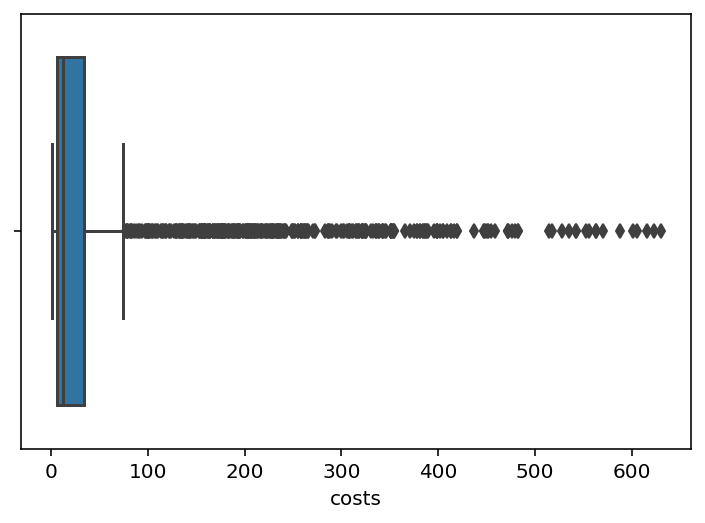

In [25]:
sns.boxplot(costs['costs'])

В графе стоимость имеет наличие большое количество аномально высоких значений. Это связано с различными каналами привлечения пользователей, их методами оплаты (которые не заданы в текущем задании), а также спецификой различных регионов.

Эти данные необходимы будут нам для всего дальнейшего анализа.

Предобработку данных на этом можно считать завершенной.

Переходим к следующему этапу.

# 2. Исследовательский анализ данных.

Приступаем к исследовательскому анализу данных.

В этом разделе мы выделим категории пользователей и выявим закономерности распределения пользователей по различным показателям, с целью выявления общих закономерностей.

## 2.1. Создание пользовательских профилей.

Первым делом для выделеия различных категорий пользователей по определенным признакам нам необходимо создать таблицу пользовательских профилей. 

Для формирования таблицы пользовательских профилей создадим функцию `get_profiles`, которая будет выявлять новых пользователей и дату, в которую эти новые пользователи пришли в компанию. Далее мы добавим признак, по которому определим которые из пользователей совершали покупки в приложении. После, сгруппируем пользователей по уникальным `id` и дате привлечения и объединим с таблицей затрат на продвижение. В конце, посчитаем стоимость привлечения отдельного пользователя и добавим к таблице с пользовательскими профилями, заменив значения в категории канала привлечения `organic` на `0`.

Готово! (За основу этой функции взята функция для создания пользовательских профилей из теоритической части.)

In [26]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    #считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    profiles['dt'] = pd.to_datetime(profiles['dt'])

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Проверим работу нашей функции. Передадим ей необходимые параметры.

In [27]:
profiles_one = get_profiles(sessions, orders, costs)

Выведем полученный датафрейм на экран.

In [28]:
display(profiles_one)

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

               dt      month  payer  acquisition_cost  
0      2019-05-07 2019-05-01   True          1.088172  
1      2019-07-09 2019-07-01  False          1.107237  
2      2019-10-01 2019-10-01  False          0.000000  
3      2019-08-22 2019-08-01  False          0.988235  
4      2019-10-02 2019-10-01  False          0.230769  
...           ...        ...    ...               ...  
150003 2019-09-28 2019-09-01  False          3.500000  
150004 2019-10-21 2019-10-01  False          0.000000  
150005 2019-07-23 2019-07-01  False          2.600000  
150006 2019-09-28 2019-09-01  False          0.205714  
150007 2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

Все получилось.

Проверим информацию о датафрейме.

In [29]:
profiles_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


В таблице отсутвуют пропуски, а все значения представленны в требуемых форматах.

Теперь выделим самый первый день привлечения клиентов в наших данных.

In [30]:
profiles_one['dt'].min()

Timestamp('2019-05-01 00:00:00')

**Это 01.05.2019 года.**

А также последний день привлечения пользователей.

In [31]:
profiles_one['dt'].max()

Timestamp('2019-10-27 00:00:00')

Этим днем является **27.10.2019 года.**

## 2.2. Исследование качества пользователей по странам.

Рассмотрим наших пользователей по критерию `регион`. 

Сгруппируем данные по признаку `region` и посчитаем общее количество уникальных пользователей на каждый регион, а также долю платящих пользователей на каждый регион.

In [32]:
profiles_one.groupby('region').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='user_id', ascending=False)

user_id     payer
region                          
United States   100002  0.069019
UK               17575  0.039829
France           17450  0.037994
Germany          14981  0.041119

In [33]:
paying_users = (profiles_one
                .pivot_table(index='region', values='payer', aggfunc=['count', 'sum', 'mean'])
                .reset_index()
                .rename(columns={'count':'all_users', 'sum':'paying_users', 'mean':'ratio'})
                .droplevel(1, axis=1)
                .sort_values(by='ratio', ascending=False)
                .style.format({'ratio':'{:.2%}'})
               )
paying_users

Из полученных данных делаем следующие заключения:

- больше всего новых пользователей было привлечени в США (около 60% всех новых пользователей). Это очень серьезный показатель;

- в Великобритании, Франции, Германии количество новых пользователей примерно одинаково;

- доля платящих пользователей также выше в США, почти 7% от общего количества. В остальных странах доля находится примерно на одном уровне - 4%.

Из этого можно сделать вывод, что **США являются самым большим и платежеспособным рынком.**

## 2.3. Исследование качества пользователей по устройствам.

Теперь рассмотрим наших пользователей по параметру используемого устройства.

Также сгруппируем пользователей по признаку `device` и посчитаем количество уникальных пользователей для каждого утсройства и долю платящих пользователей в группе.

In [34]:
profiles_one.groupby('device').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='user_id', ascending=False)

user_id     payer
device                    
iPhone     54479  0.062079
Android    35032  0.058518
PC         30455  0.050468
Mac        30042  0.063644

In [35]:
paying_users = (profiles_one
                .pivot_table(index='device', values='payer', aggfunc=['count', 'sum', 'mean'])
                .reset_index()
                .rename(columns={'count':'all_users', 'sum':'paying_users', 'mean':'ratio'})
                .droplevel(1, axis=1)
                .sort_values(by='ratio', ascending=False)
                .style.format({'ratio':'{:.2%}'})
               )
paying_users

Здесь мы видим более равномерное распределение, однако можно выделить следующие закономерности:

- больше всего новых пользователей используют `iPhone`;

- далее идут пользователи использующие `Android`-устройства;

- количество пользователей, пользуюшихся стационарными компьютерами, `PC` и `Mac` равно - около 30000;

- доля платящих пользователей также имеет небольшое расхождение. Можно выделить, что пользователи `iPhone` и `Mac` платят чаще, а пользователи `PC` реже.

- также необходимо отметить, что пользователи предпочитают мобильные устройства стационарным.

## 2.4. Исследование качества пользователей по каналам привлечения.

И, наконец, проведем исследование пользователей по признаку - канал привлечения. Для этого мы добавляли в датафрейм данные о каналах привлечения.

Порядок такой же: 

- группируем данные по признаку `channel`;

- считаем количество уникальных пользоватеелй на канал;

- считаем долю платящих пользователей на канал.

In [36]:
profiles_one.groupby('channel').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='user_id', ascending=False)

user_id     payer
channel                              
organic               56439  0.020553
FaceBoom              29144  0.122049
TipTop                19561  0.096007
OppleCreativeMedia     8605  0.027077
LeapBob                8553  0.030633
WahooNetBanner         8553  0.052964
RocketSuperAds         4448  0.079137
MediaTornado           4364  0.035747
YRabbit                4312  0.038265
AdNonSense             3880  0.113402
lambdaMediaAds         2149  0.104700

In [37]:
paying_users = (profiles_one
                .pivot_table(index='channel', values='payer', aggfunc=['count', 'sum', 'mean'])
                .reset_index()
                .rename(columns={'count':'all_users', 'sum':'paying_users', 'mean':'ratio'})
                .droplevel(1, axis=1)
                .sort_values(by='ratio', ascending=False)
                .style.format({'ratio':'{:.2%}'})
               )
paying_users

Отметим следующие факты: 

- наибольшее количество пользователей пришли к приложению естественным путем;

- из специальных каналов привлечения больше всего пользователей было привлечено через канал `FaceBoom`;

- на втором месте канал `TipTop`;

- хуже всего пользователей удалось привлекать через каналы `AdNonSense` и `lambdaMediaAds`;

- наивысшая доля платящих пользователей наблюдается в каналах `FaceBoom`, `TipTop` и `lambdaMediaAds`.

Итак, мы можем заключить промежуточные выводы:

- **США являются самым большим и платежным рынком - с очень большим перевесом**;

- **пользователи предпочитают мобильные устройства**;

- **с помощью них же они совершают больше покупок**;

- **самыми эффективными в плане количества привлеченных пользователей являются каналы `FaceBoom` и `TipTop`. Они же привлекают больший процент платящих пользователей**.

# 3. Маркетиг.

В этом разделе мы будем оценивать затраты на продвижение продукта и их эфективность.

В нашем распоряжении имеются данные об общем количестве затрат на рекламу по различным каналам за рассматриваемый период.

## 3.1. Маркетинговые расходы и их распределение.

Определим общие расходы на продвижение за весь период.

In [38]:
print('Общие затраты на привлечение новых пользователей:', costs['costs'].sum())

Общие затраты на привлечение новых пользователей: 105497.30000000002


Расходы на рекламу за весь период составили: 105 497.30 ед.

Теперь посмотрим как эти расходы распределены по каналам привлечения. Сгруппируем данные по признаку `channel` и посчитаем общую сумму расходов для каждого канала.

In [39]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Мы видим, что каналы `FaceBoom` и `TipTop`, которые привлекли больше всех пользователей, потребовали и больше всего затрат - в сумме на оба канала более 85% рекламного бюджета. Меньше всего расходов было на каналы `MediaTornado` и `YRabbit`.

Визуализируем расходы на каждый канал в динамике. 

Text(11.456536458333332, 0.5, 'Стоимость, ед.')

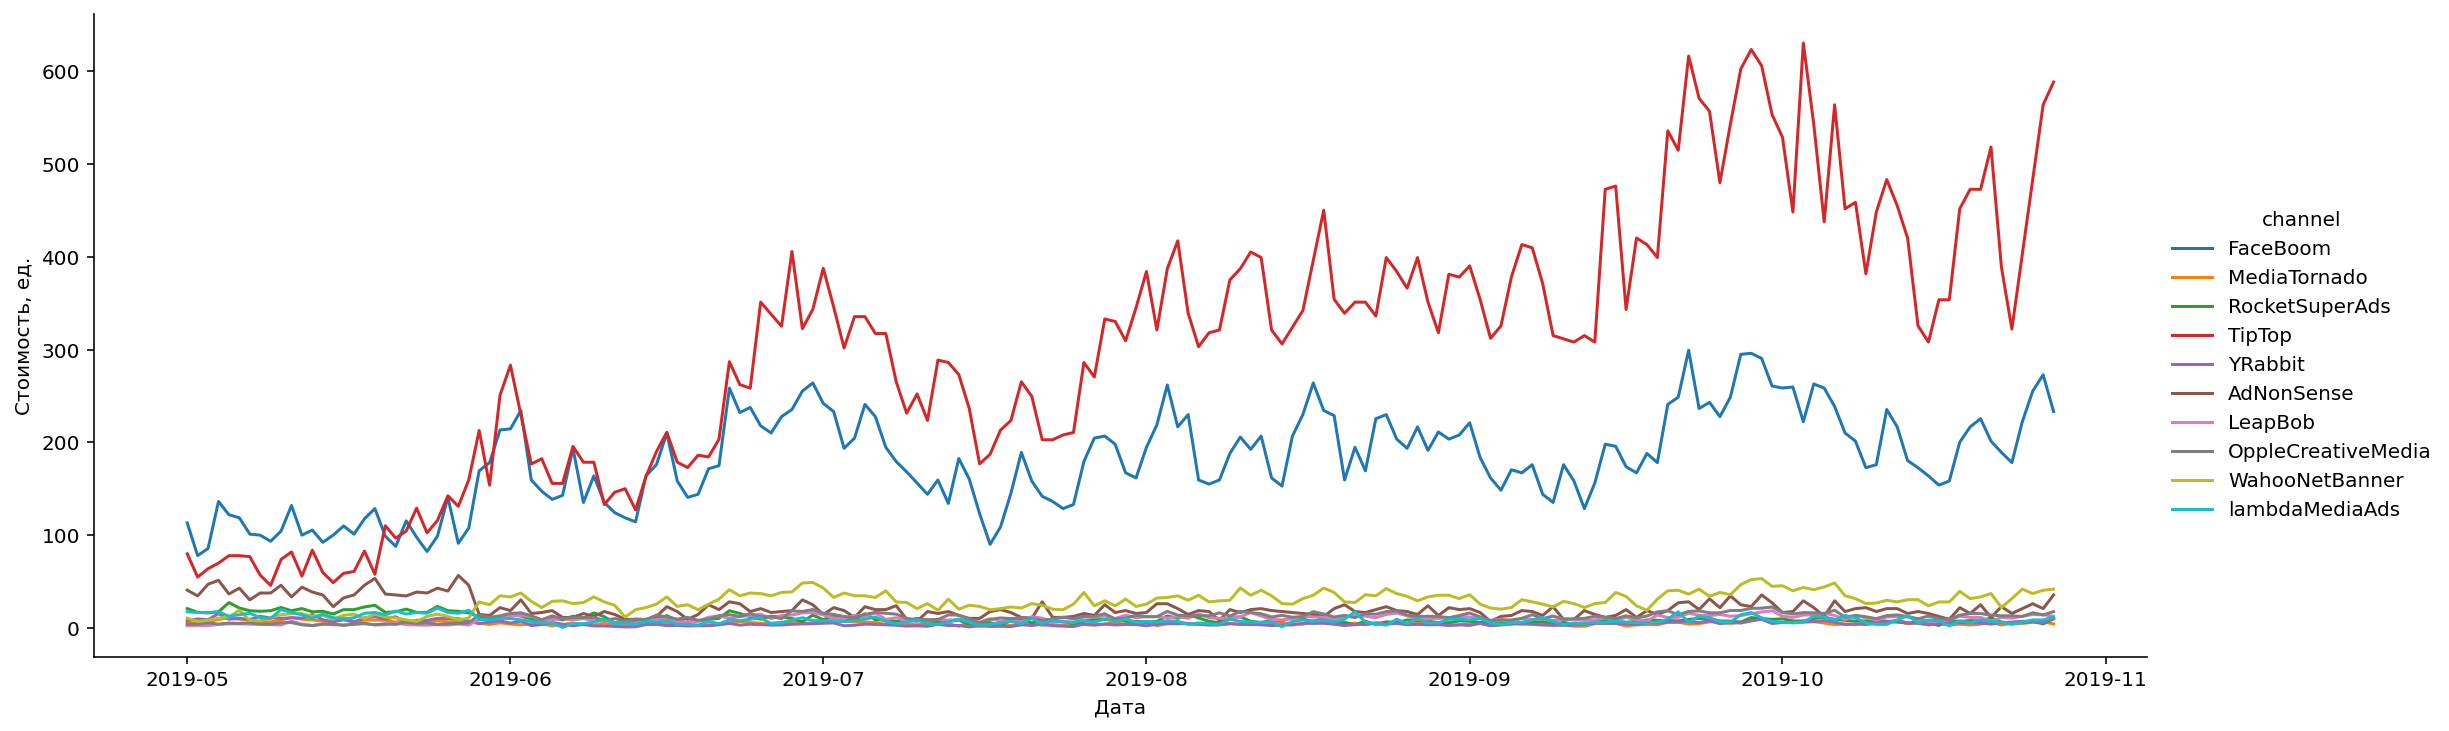

In [40]:
sns.relplot(x='dt', y='costs', data=costs, hue='channel', kind='line', height=5, aspect=3)
plt.xlabel('Дата')
plt.ylabel('Стоимость, ед.')

Мы видим, что расходы на привлечение новых пользователей по каналам `FaceBoom` и `TipTop` увеличивались за рассматриваемый период и были нестабильны. Мы можем выделить большие колебания графиков.

Также заметим, что затраты на другие источники привлечения пользователй в этот же период были стабильны.

Также рассмотрим общие затраты на маркетинг по всему проекту за весь период по месяцам.

In [41]:
costs['month'] = costs['dt'].astype('datetime64[M]')

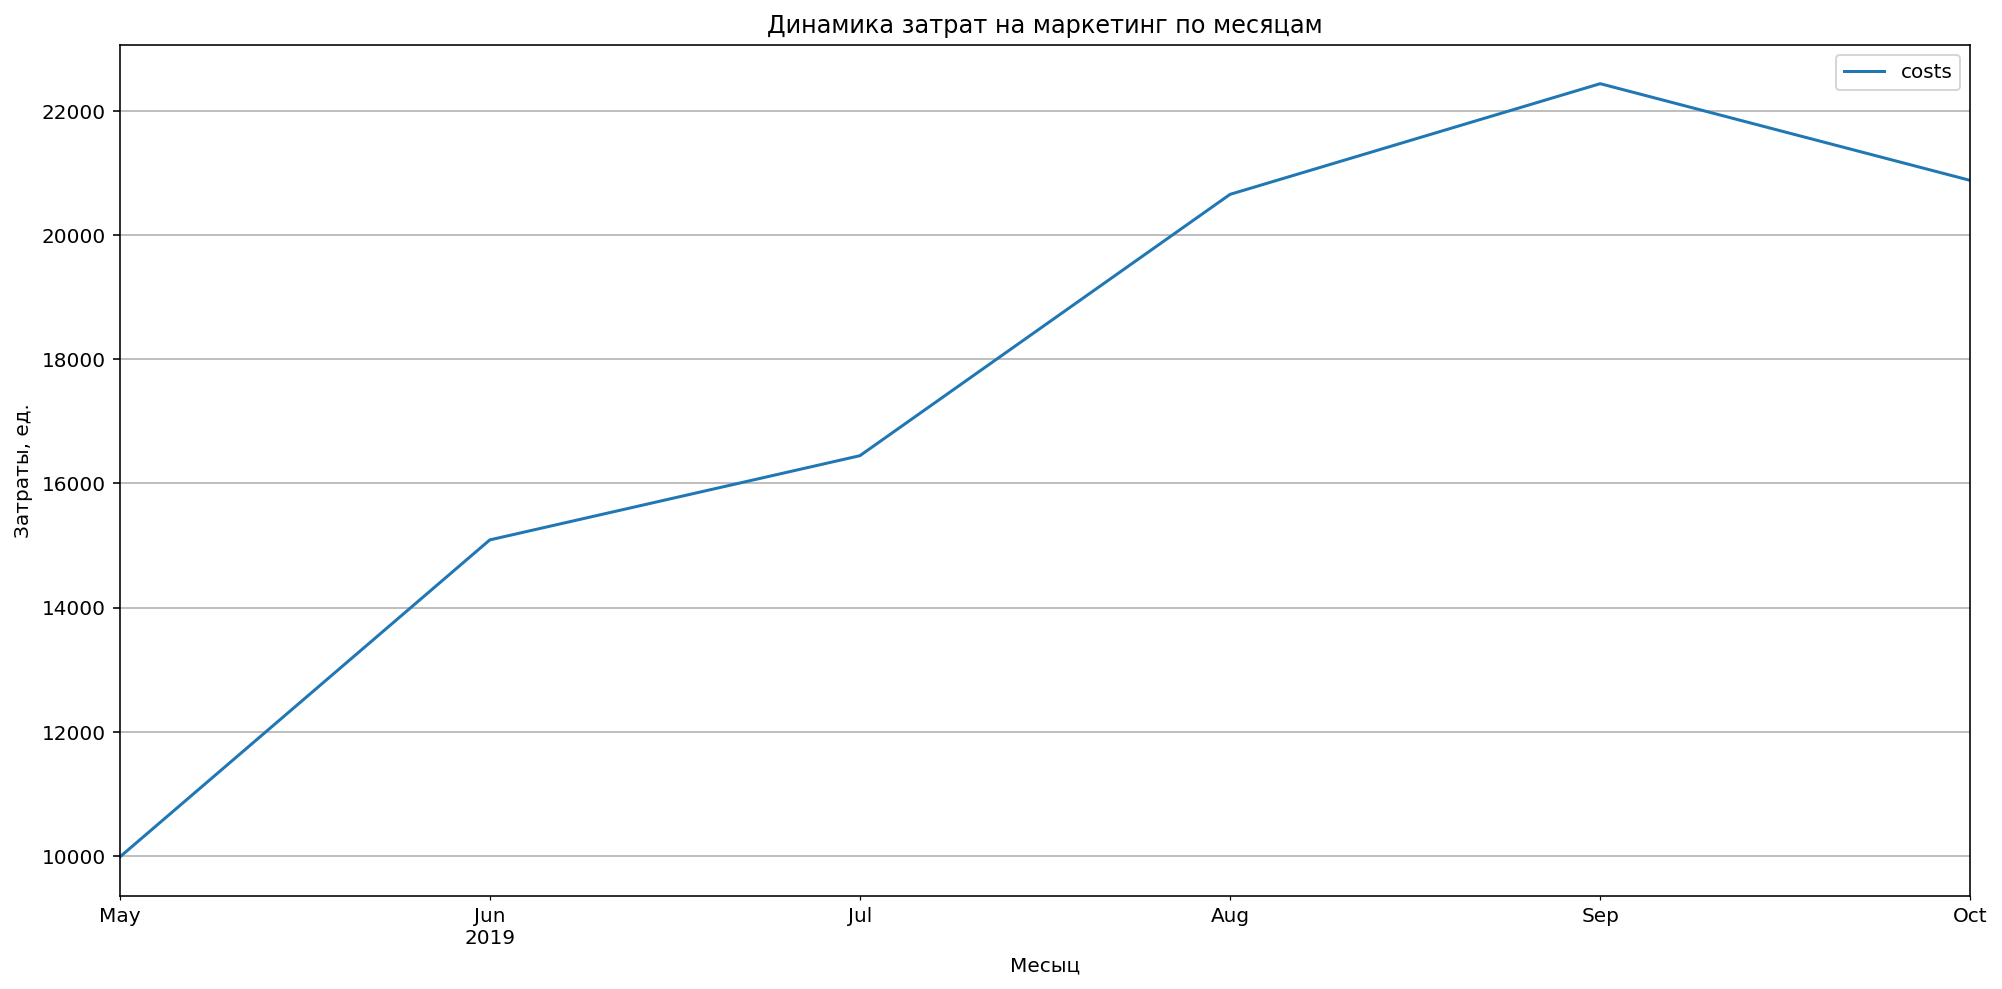

In [42]:
costs.groupby('month').agg({'costs':'sum'}).plot(grid=True, figsize=(14, 7))
plt.ylabel('Затраты, ед.')
plt.xlabel('Месыц')
plt.title('Динамика затрат на маркетинг по месяцам')
plt.tight_layout()

Мы видим, что затраты на маркетинг стабильно росли все время кроме последнего месяца.

И в дополнение посмотрим на затраты на маркетинг по каналам за весь период по месяцам.

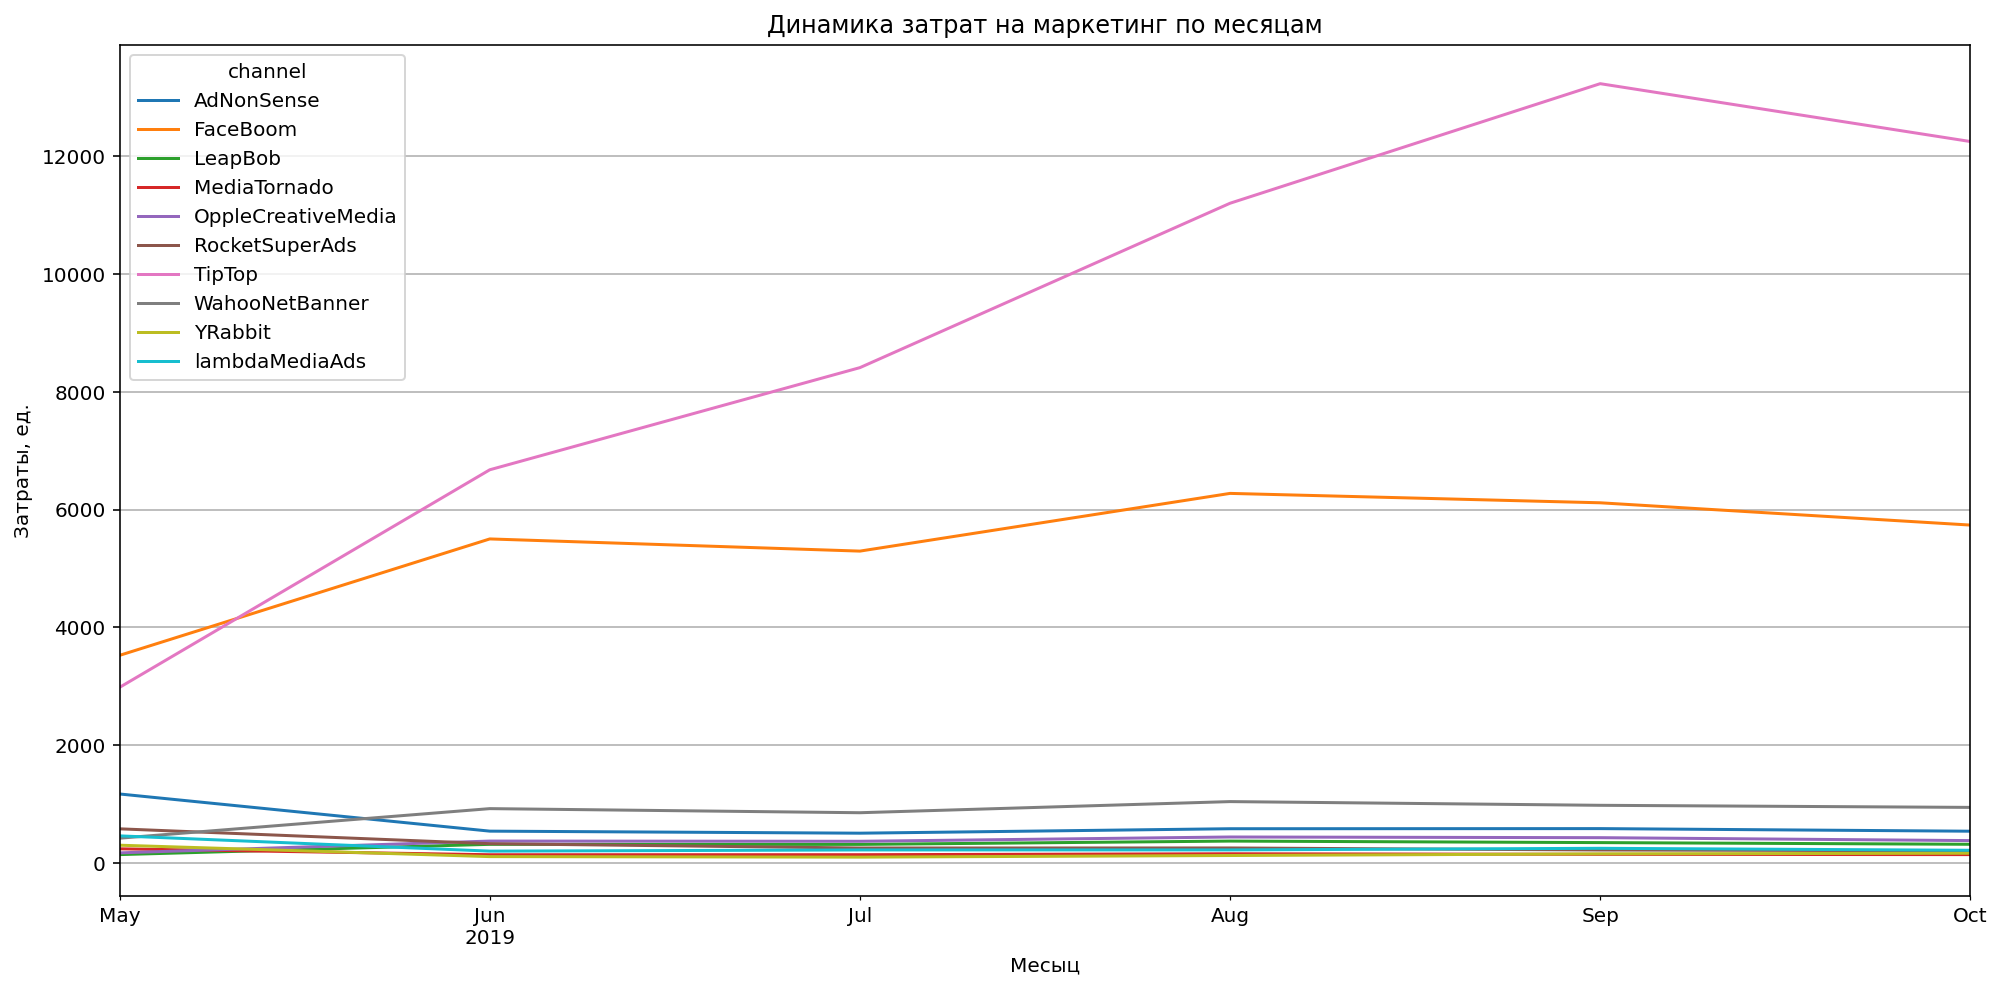

In [43]:
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(14, 7))
plt.ylabel('Затраты, ед.')
plt.xlabel('Месыц')
plt.title('Динамика затрат на маркетинг по месяцам')
plt.tight_layout() 

Здесь важно отметить, что затраты росли только на продвижение по каналам `TipTop` и `FaceBoom`. Причем по каналу `FaceBoom` затраты остановили свой рост в июне и дальше были лишь незначительные колебания.

Это еще скажется в будущем при проведении расследования причин убытков компании за последний период.

## 3.2. Маркетинговые расходы на одного пользователя и метрика САС.

Теперь рассмотрим сколько обходилось компании привлечение одного пользователя в среднем за рассматриваемый период.

При рассмотрении исключим пользователей, которые пришли естественным путем, чтобы не исказить данные.

In [44]:
print('Затраты на привлечение одного пользователя:'\
      , profiles_one.query('acquisition_cost != 0')['acquisition_cost'].mean())

Затраты на привлечение одного пользователя: 1.1274813239427588


Получается, для привлечения одного пользователя, компании в среднем необходимо потратить 1.13 ед.

Теперь взглянем как это соотносится с средней стоимостью привлечения пользователей для каждого канала. Для этого сгруппируем данные по параметру `channel` и посчитаем среднее значение ранее высчитаного параметра `acquisition_cost`. (Этот параметр мы высчитывали на этапе формирования пользовательских профилей как резудбтат деления количества затраченных средств на число пользователей.)

In [45]:
profiles_one.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

Мы видим, что в лидерах те же каналы, что и по количеству привлеченых пользователей - `FaceBoom` и `TipTop`, причем канал `TipTop` с большим отрывом впереди - стоимость привлечения одного пользователя в среднем обходится 2.8 ед. 

Отобразим на графике динамику изменения средней стоимости привлечения пользователя (САС) по различным каналам.

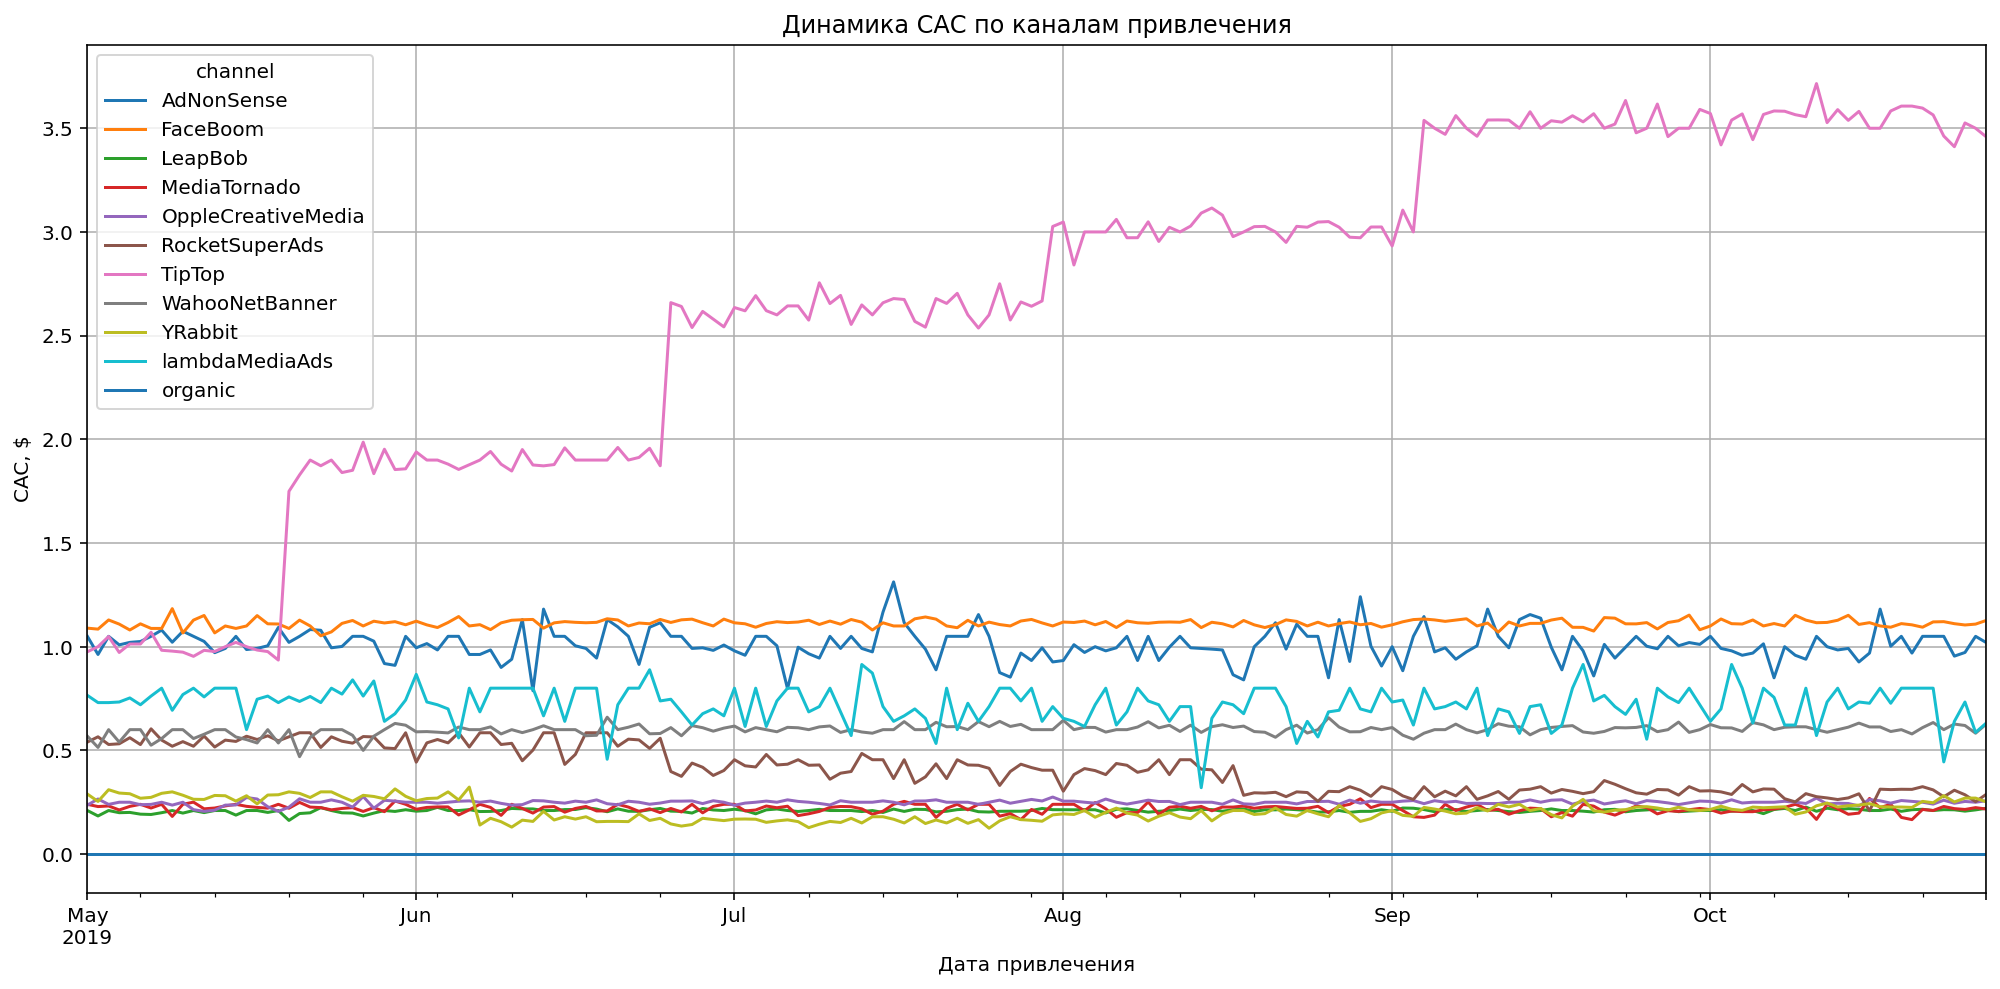

In [46]:
profiles_one.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(14, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.tight_layout()

Здесь мы видим следующую картину:

- средние затраты на привлечение пользователей через канал `TipTop` постоянно увеличивались со временем, причем необходимо отметить ступенчатый характер увеличения;

- средние затраты по остальным каналам были стабильны на протяжении всего периода.

Следовательно мы заключаем, что происходило увелечение расходов на привлечение новых пользователей, вызванное только увеличением расходов только по одному каналу - `TipTop`.

# 4. Оценка окупаемости рекламы.

Приступим к оценке окупаемости рекламы или `LTV`.

Для этого создадим следующие функции.

Функция для расчета `LTV` и `ROI` (окупаемость инвестиций). В этой функции мы будем работать с данными пользовательских профилей и данными о покупках пользователей. Оценивать мы будем по текущей дате на календаре 01.11.2019 года, а в соответствии с утвержденным бизнес_планом (`observation_date`=(2019, 10, 1)), пользователи должны окупаться через две недели, так что рассматриваемый горизонт равен 14 дней (`horizon_days`=14). Также мы будем рассматривать наши показатели в различных срезах для чего добавим параметр `dimensions`, в котором будем указывать требуемый признак.

Искомая функция имеет следующий вид. (За основу этой функции взята функция для расчета LTV и ROI из теоритеческой части.)

В результате вызова функции мы получим следующие результаты:

- таблицу с "сырыми" данными;

- таблицу LTV;

- таблицу динамики LTV;

- таблицу ROI;

- таблицу динаимики ROI.

In [47]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Теперь создадим функцию для сглаживания фрейма с использованием скользящего среднего с целью построения более наглядных и читаемых графиков.

Эта функция будет иметь следующий вид. (За основу этой функции взята функция для сглаживания фрейма из теоритеческой части.)

In [48]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Также нам потребуется написать функцию для визуализации `LTV` и `ROI`. При вызове этой функции мы будем передавать ей данный, полученые при вызове функции для расчета LTV и ROI: 

- таблица LTV;

- таблица динамики LTV;

- таблица ROI;

- таблица динамики ROI;

- рассматриваемый горизонт;

- окно скользящего среднего.

В результате мы получим пять графиков, на основании анализа которых сможем сделать опрделенные выводы.

(За основу этой функции взята функция для визуализации LTV и ROI из теоритеческой части.)

In [49]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Зададим переменные с датой момента анализа и горизонтом анализа.

In [50]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Также дополнительно перед проведением дальнейшего анализа отфильтруем данные по каналу привлечения убрав естественный канал привлечения, который может повлиять на наши результаты и выводы.

In [51]:
profiles = profiles_one.query('channel != "organic"')

Приступим к оценке окупаемости.

## 4.1. Общая окупаемость рекламы.

Первым делом оценим общую окупаемость по всему проекту за рассматриваемый период.

Вызовем функцию `get_ltv` и не будем указывать параметр `dimensions`, чтобы отобразить общую статистику.

In [52]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

Вызовем функцию `plot_ltv_roi` для визуализации полученных результатов.

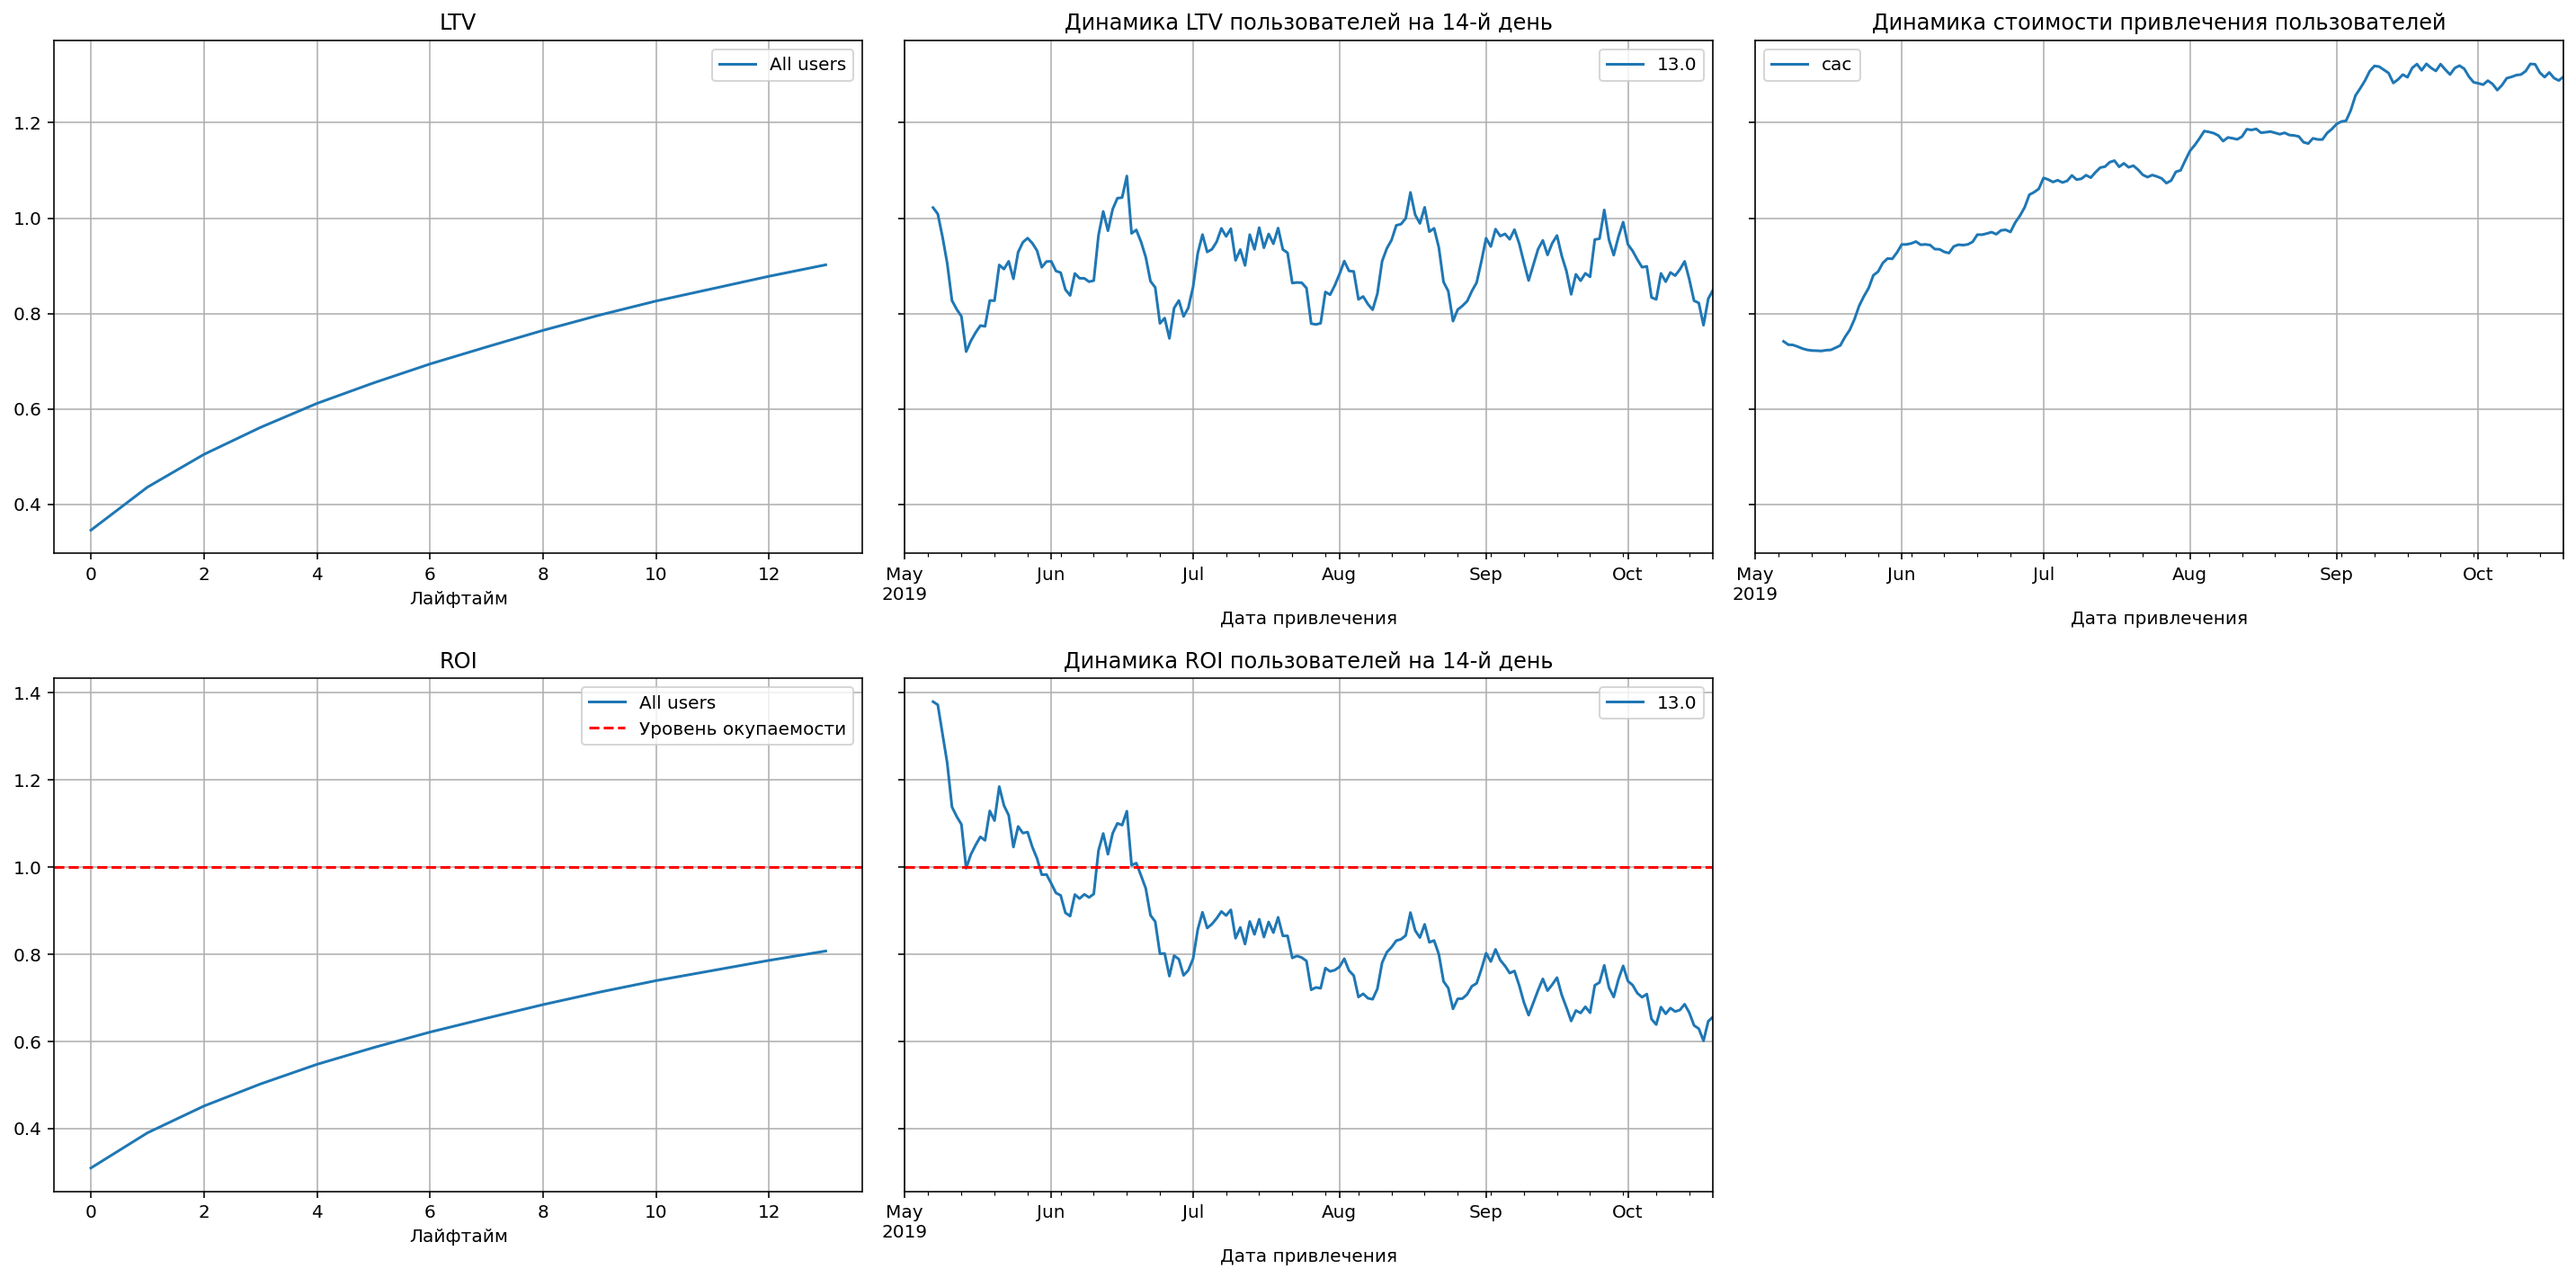

In [53]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По полученным графикам заключаем следующее:

- LTV во времени ведет себя нестабильно, но среднее значение держится в районе одного значения;

- динамика САС начиная с июня резко идет на увеличение, замедляясь с октябрю;

- ROI не выходит на уровень окупаемости, останавливаясь на уровне 0,98;

- динамика ROI во времени идет на уменьшение, что подозрительно коррелирует с динамикой САС.

Мы видим увеличение затрат на привлечение новых пользователей (что мы обнаружили ранее), а также тревожную динамику одновременного снижения коэфициента ROI.

Попробуем найти причины, по которым это происходит.

## 4.2. Окупаемость рекламы по каналам привлечения.

Проверим окупаемость продвижения по различным каналам.

Для этого зададим параметр `dimension` = ['channel']. 

In [54]:
dimensions = ['channel']

Вызовем функции `get_ltv` и `plot_ltv_roi` с разбивкой по каналам привлечения.

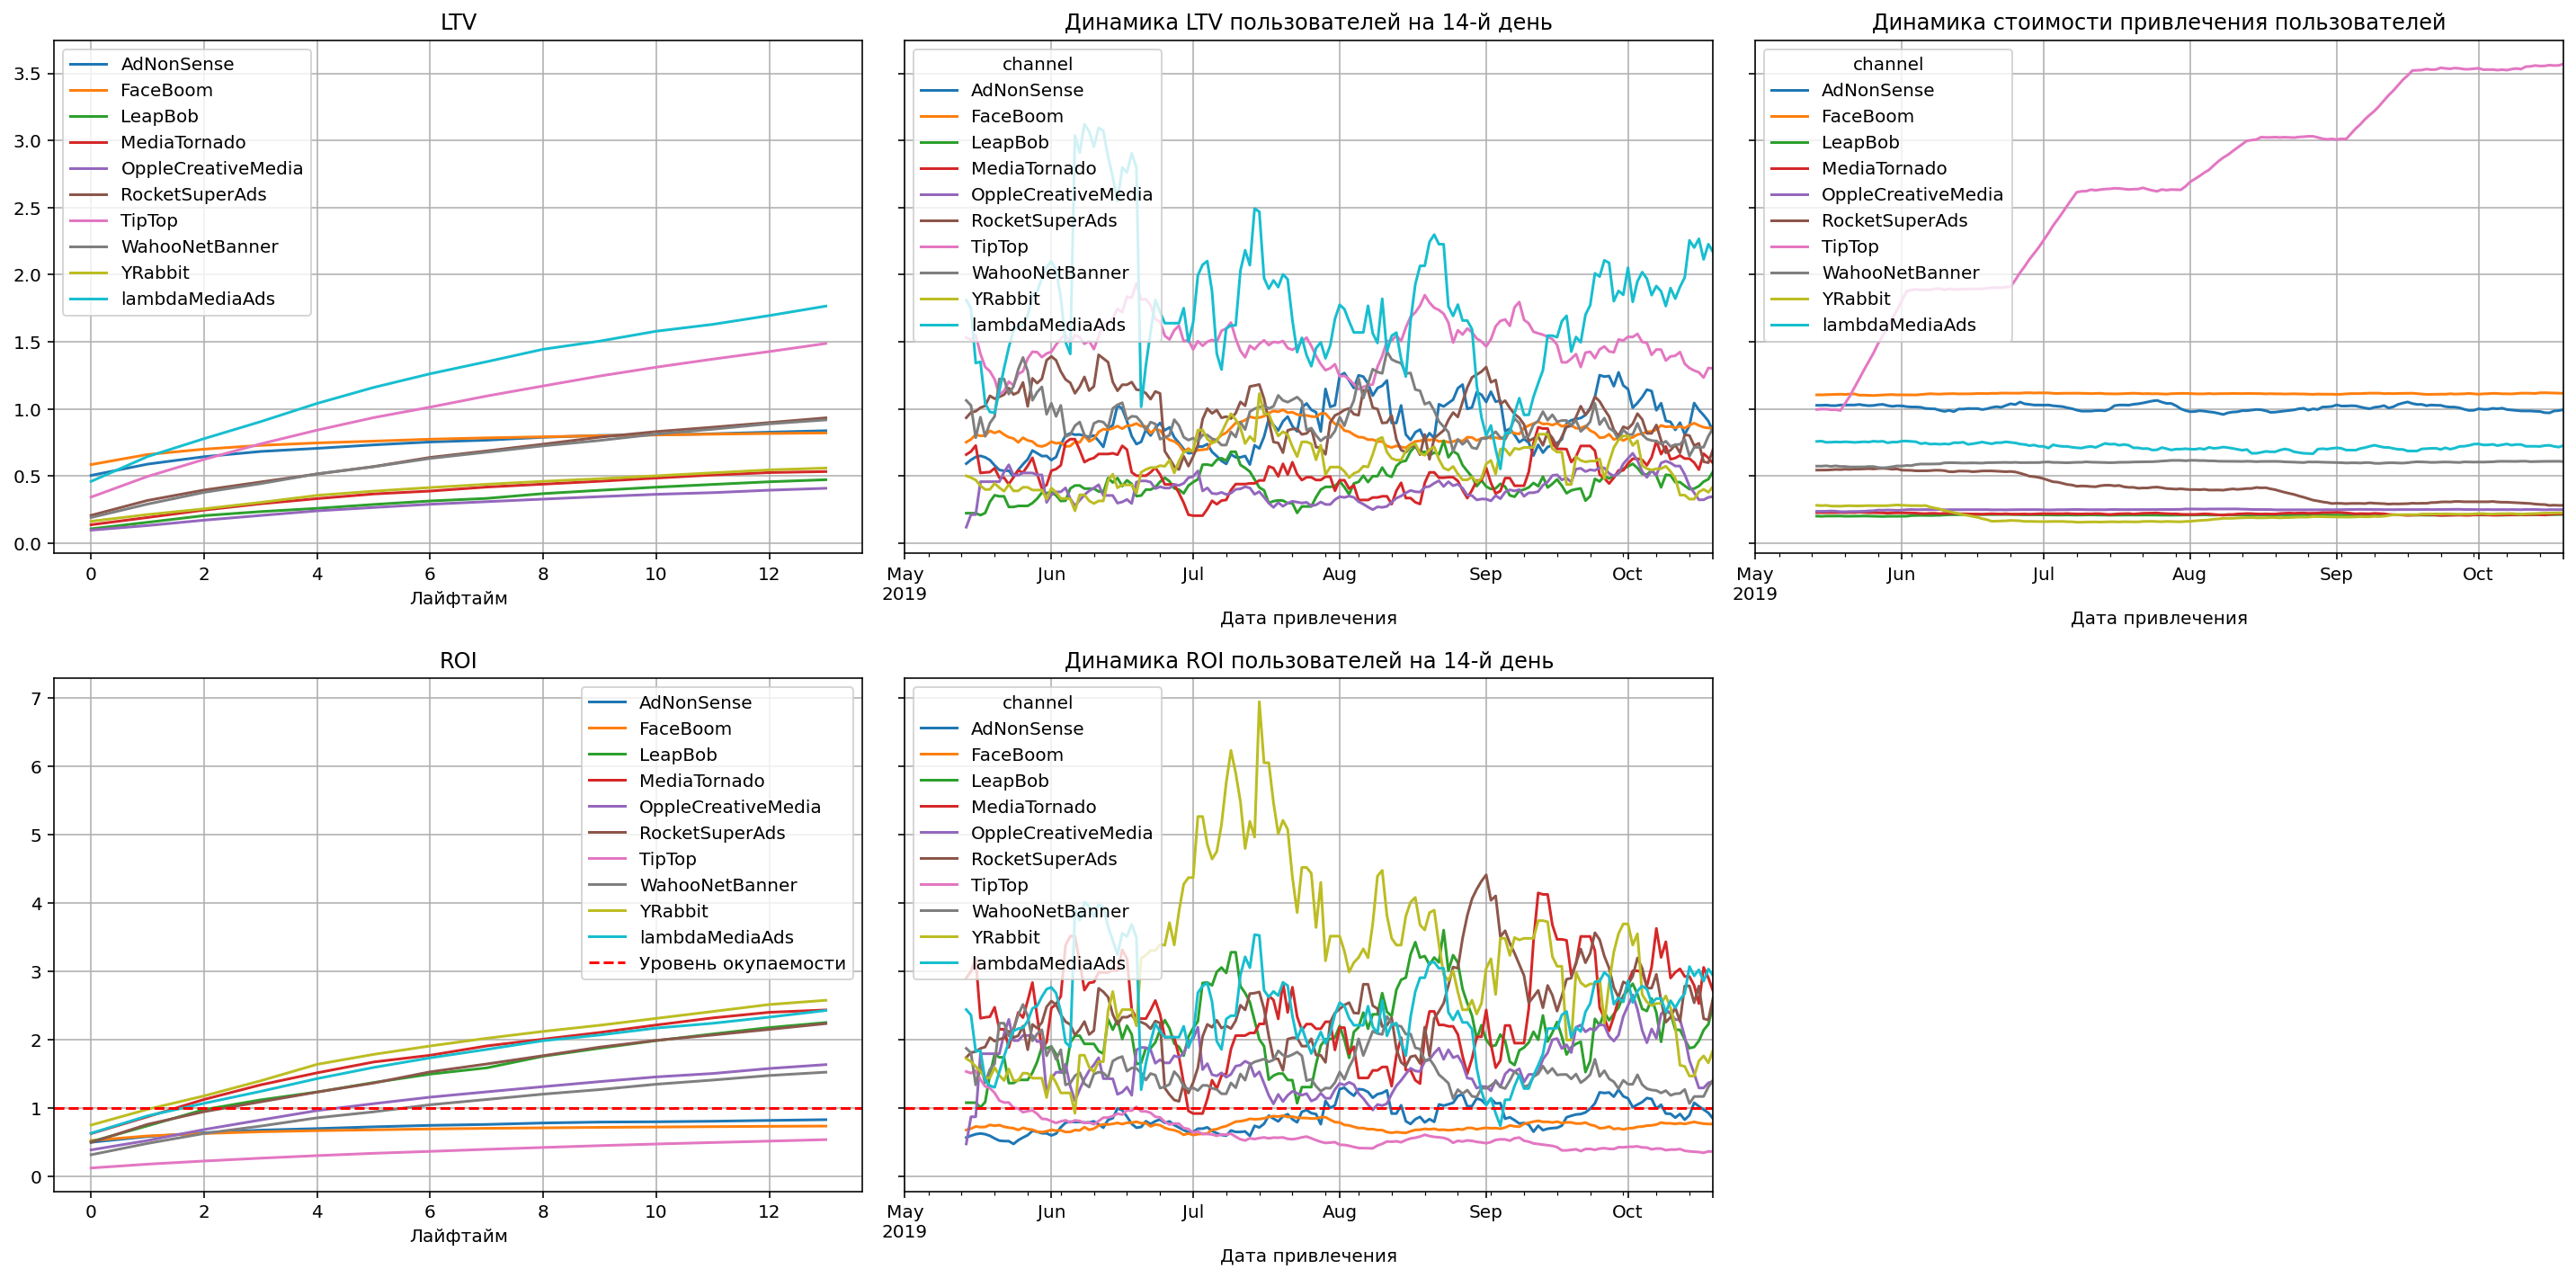

In [55]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Здесь мы видим:

- наилучшие показатели привлечения пользователей по каналам `lambdaMediaAds` и `TipTop`;

- динамика LTV на 14 день для всех каналов во времени стабильна;

- по динамике LTV мы видим, что лучшее показатели показывают каналы `lambdaMediaAds`, `TipTop`. Также дополнительно можно выделить, что выделяются заметные колебания в динамике. Только канал `FaceBoom` показывает самые стабильные показатели;

- выявленное нами ранее увеличение стоимости привлечения пользователей по каналу `TipTop` в динамике при стабильных показателях по другим каналам, что говорит о дополнительных вложениях в этот канал;

- лучший показатель ROI у канала `YRabbit`;

- ROI только трех каналов не выходит на уровень окупаемости - это `TipTop`, `FaceBoom`,  `AdNonSense`;

- динамика ROI этих трех каналов стабильно ниже уровня окупаемости, за небольшими исключениями.

Можем сделать итог, что **несмотря на большие инвестиции, каналы `TipTop` и `FaceBoom` не выходят на уровень окупаемости**.

## 4.3. Окупаемость рекламы по регионам пользователей.

Теперь оценим окупаемость рекламы по различным регионам.

Для этого параметр `dimensions` принимает значение `'region'`.

In [56]:
dimensions = ['region']

Вызываем функции `get_ltv` и `plot_ltv_roi` с разбивкой по регионам.

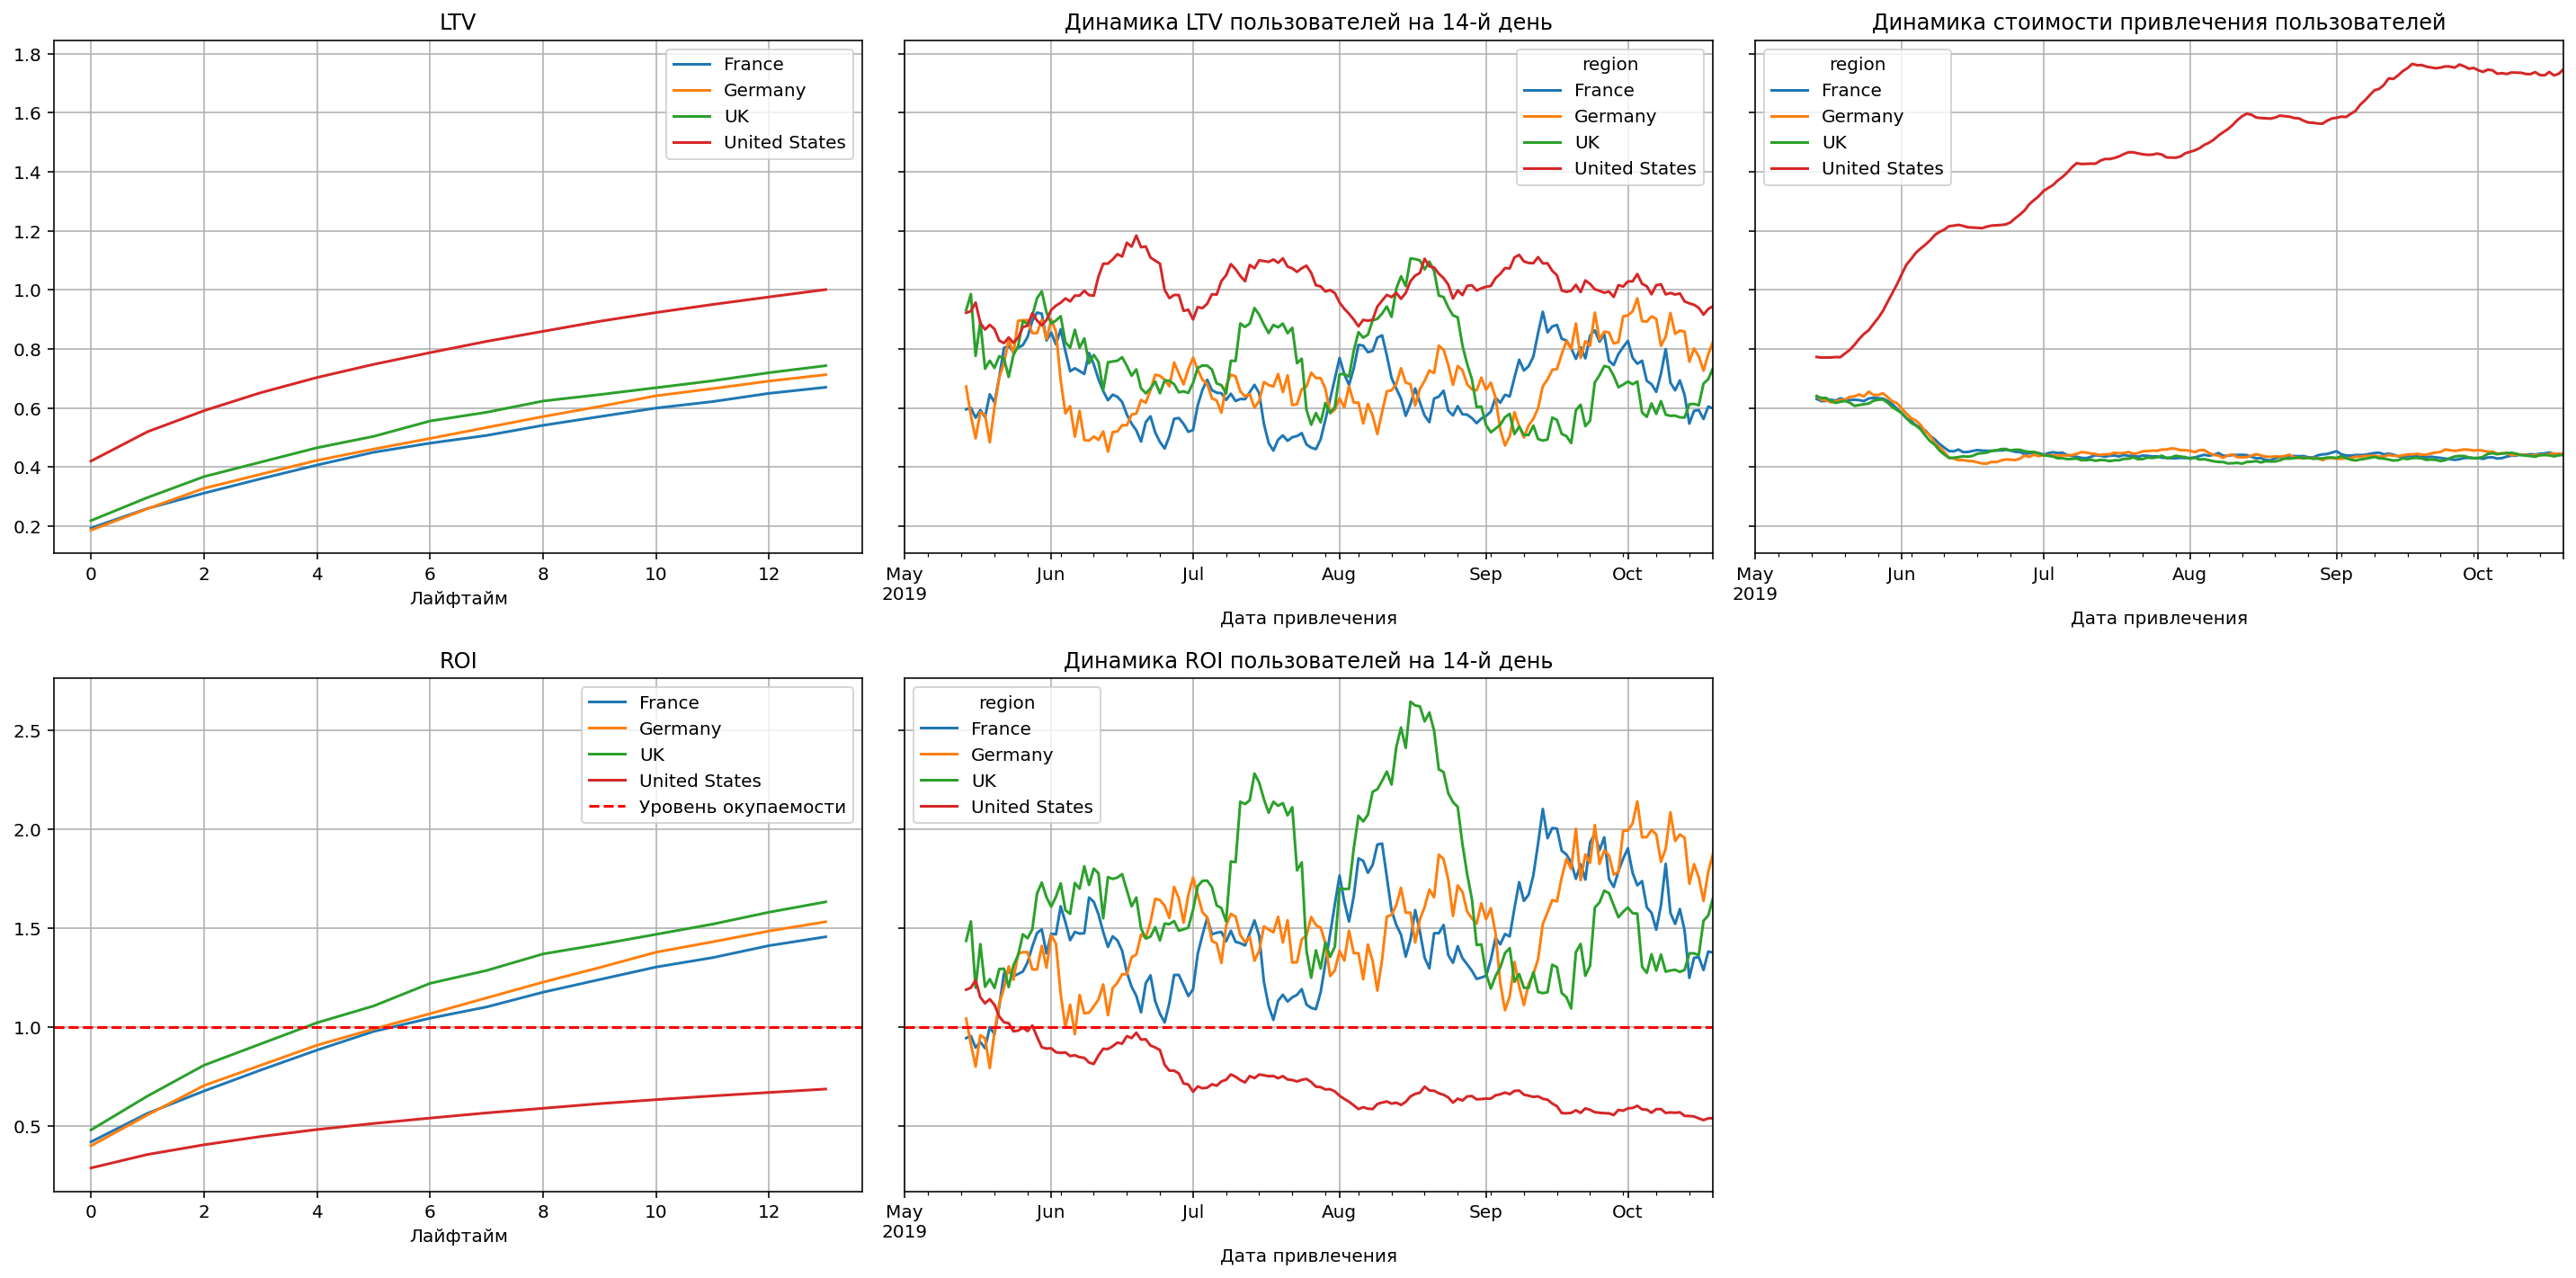

In [57]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

В этом случае имеем следующие выводы:

- наилучший коэффициент LTV показывают пользователи из США;

- увеличение стоимости привлечения пользователей (САС) для США, явно соответствующий динамике САС для канала `TipTop`;

- динамика САС остальных стран в один момент с резким ростом САС в США идет на убыль;

- коэффициент ROI ВБ, Германии, Франции уверенно преодолевает порог окупаемости;

- ROI США не выходит на уровень окупаемости;

- уменьшие ROI США во времени с выходом нижи уровня окупаемости.

Здесь мы видим **явное соответствие показателей ROI, CAC и динамики ROI для США соответствующим показателям для канала привлечения пользователей `TipTop`**. Этот факт надо будет проверить в будущем.

**Также дополнительно необходимо добавить, что с ростом стоимости привлечения пользователей в США, стоимость привлечения пользователей в других странах снизилась.**

На рынках стран ВБ, Германии и Франции бизнес-показатели в норме.

## 4.4. Окупаемость рекламы по используемым устройствам.

И последнее, проверим окупаемость продвижения продукта по используемым устройствам.

Для этого зададим параметр `dimensions` = ['device'].

In [58]:
dimensions = ['device']

Вызовем функции `get_ltv` и `plot_ltv_roi` с разбивкой по используемым устройствам.

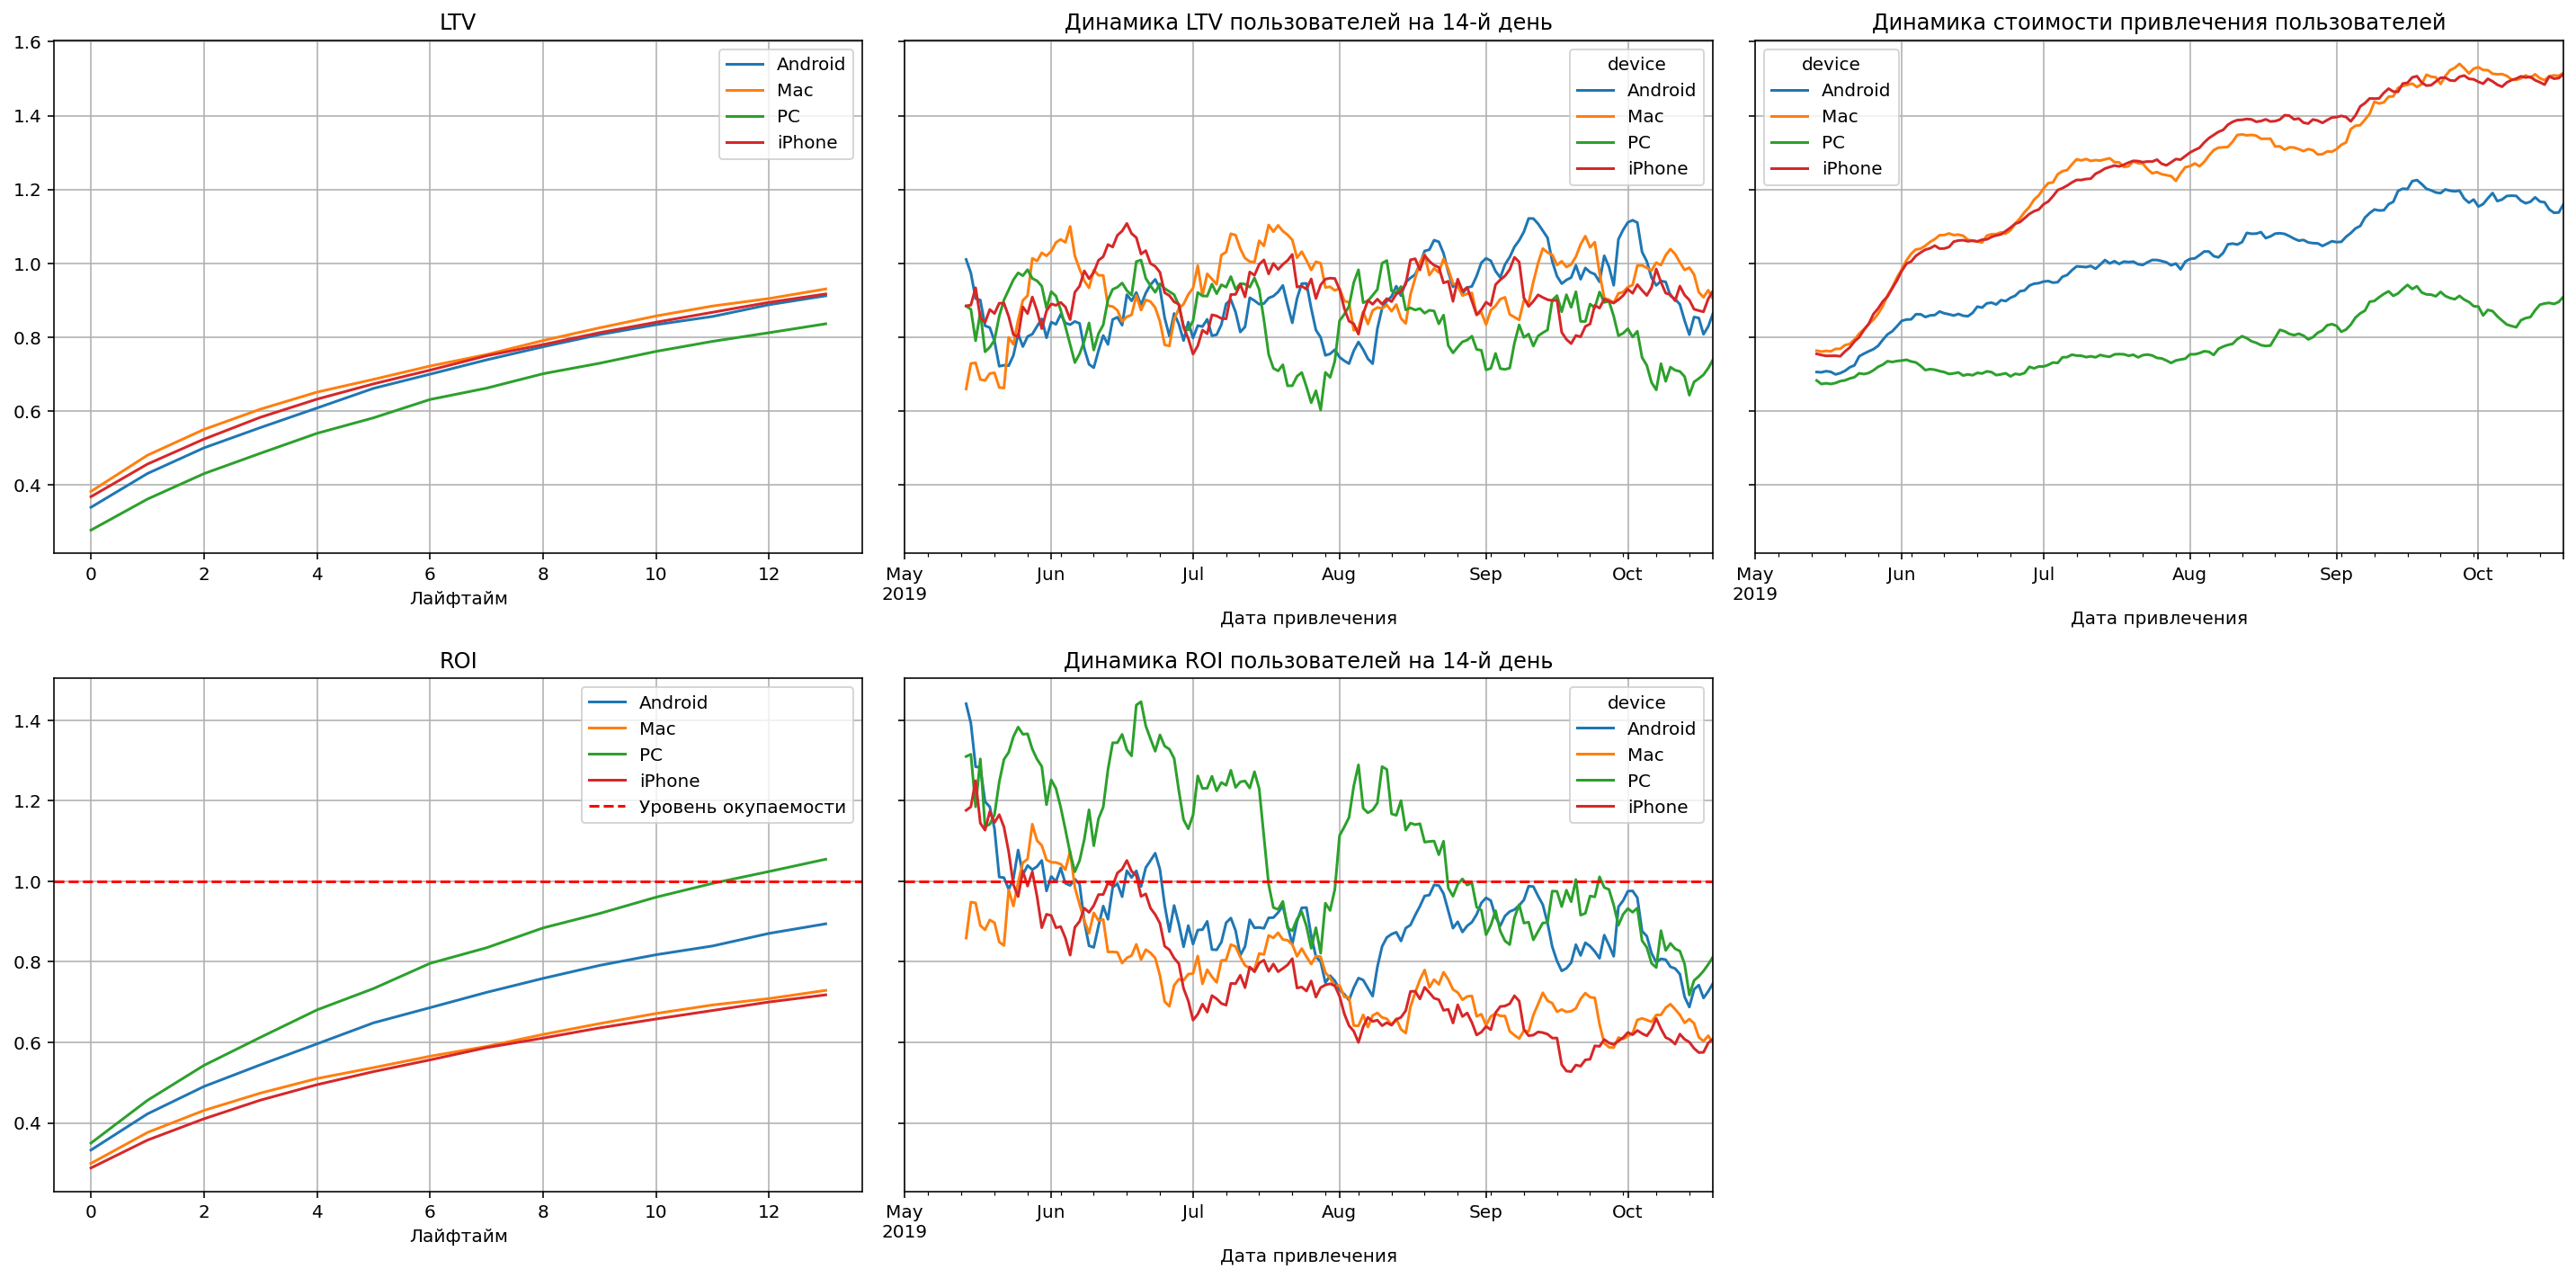

In [59]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Наблюдаем следующую картину:

- примерно равный LTV для всех устройств, однако отметим, что для `PC` он ниже всех;

- увеличение показателя САС во времени для всех устройств, особенно для `iPhone` и `Mac`;

- только ROI устройств `PC` превышает уровень окупаемости;

- ROI устройств `iPhone` и `Mac` одинаков и не выходит на уровень окупаемости;

- динамика ROI для всех устройств идет на убывание, однако для `iPhone` и `Mac` этот показатель падает сильнее.

По выявленным закономерностям можно заключить, что:

- **пользователи `iPhone` и `Mac` демонстрируют худшие показатели окупаемости, заметно уменьшающиеся во времени**;

- это может быть вызвано большим распространением этих устройств в США, которые также демонстрируют неважные показатели;

- хороший ROI демонстрируют только пользователи `PC`;

- ROI пользователей `Android` к концу рассматриваемого периода также не демонстрирует окупаемости.


**В итоге у нас есть предположение о причинах убыточности в последнее время - это вложение в продвижение продукта на территории США через каналы `TipTop` и `FaceBoom`. Это требует дополнительного подтверждения.**

# 5. Оценка конверсии и удержание пользователей пользователей.

Теперь нам необходимо рассмотреть показатели конверсии и удержания пользователей пользователей.

Для этого также составим следующие функции.

Создадим функцию для расчета удержания пользователей.

Этой функции для расчета мы будем передавать следующие данные:  

- таблицу пользовательских профилей;

- таблицу с сессиями пользователей;

- дату анализа;

- горизонт анализа;

- переменный параметр `dimensions`, в котором мы будем задавать различные группы для анализа.

В результате примениния функции мы получим следующие результаты:

- таблицу "сырых" данных;

- таблицу с коэффициентом удержания пользователй;

- таблицу динамики удержания пользователей во времени.

(За основу взята функция расчета удержания пользователей из теоритической части.)

In [60]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Также составим функцию расчета конверсии.

Этой функции мы будем передавать следующие данные:

- таблицу пользовательских профилей;

- таблицу с покупками пользователей;

- дату анализа;

- горизонт анализа;

- переменный параметр `dimensions`, в котором мы будем задавать необходимую группу.

В результате использования этой функции мы получим следующие результаты:

- таблицу "сырых" данных;

- таблицу конверсии пользователей;

- таблицу динамики конверсии пользователей во времени.

(За основу взята функция расчета конверсии из теоритической части.)

In [61]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Теперь нам необходимо визуализировать полученные результаты. Для этого составим две функции, которые будут строить графики конверсии и удержания по задаваемым параметрам.

Зададим функцию для визуализации удержания пользователей. Передадим ей для расчетов следующие параметры:

- таблицу удержания пользователей;

- таблицу динамики пользователей;

- горизонт анализа;

- размер скользящего среднего.

В этой функции для сглаживания колебаний графиков мы будем использовать ранее заданую функцию для сглаживания фрейма `filter_data`.

В результате работы функции визуализации удержания пользователей мы получим четыре графика: по два графика с разделением на платящих и неплатящих пользователей показывающих коэффициент удержания удержания пользователей и динамику удержания пользователей.

In [62]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Также зададим функцию для визуализации конверсии. Передадим ей для расчетов следующие параметры:

- таблицу конверсии;

- таблицу динамики конверсии;

- горизонт анализа;

- размер скользящего среднего.

В этой функции для сглаживания колебаний графиков мы будем использовать ранее заданую функцию для сглаживания фрейма `filter_data`.

В результате работы функции визуализации конверсии мы получим два графика с разделением на платящих и неплатящих пользователей показывающих коэффициент конверсии.

In [63]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Приступим к расчетам.

## 5.1. Оценка конверсии и удержания пользователей по каналам привлечения.

Для начала посчитаем конверсию пользователей по каналам привлечения. Для этого параметр `dimensions` примет значение `'channel'`. И вызовем две функции: `get_conversion` и `plot_conversion`.

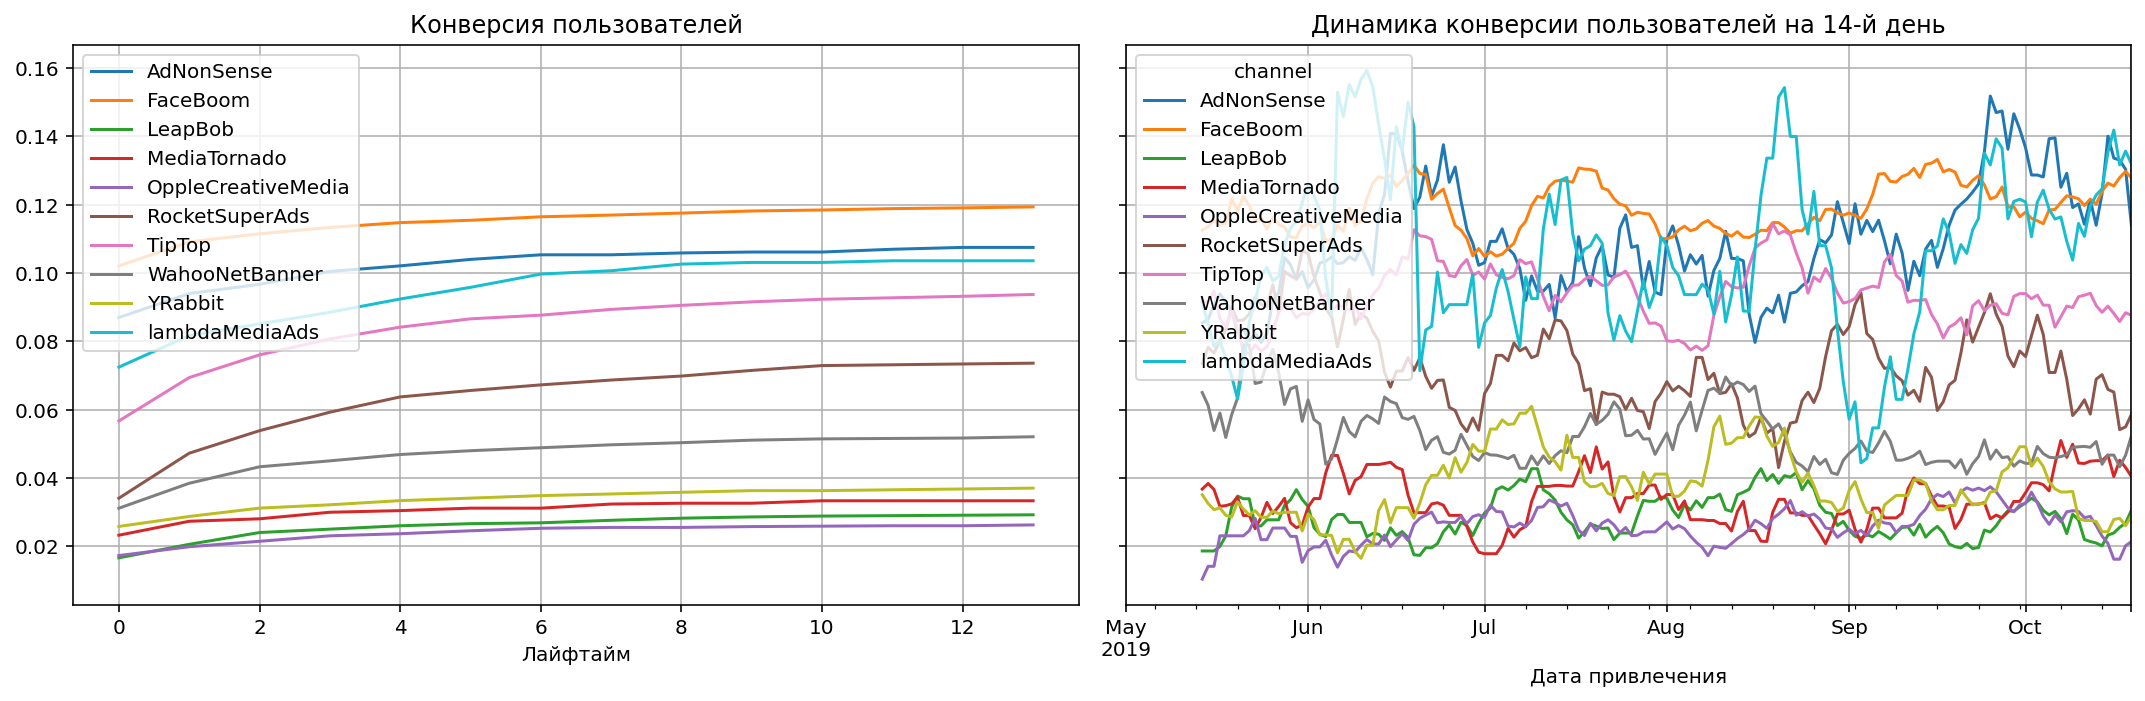

In [64]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Мы видим, что самые высокие пказатели конверсии у каналов `FaceBoom`, `AdNonSense` и `lambdaMediaAds`, а также можно добавить сюда канал `TipTop`.

Самые низкие показатели конверсии у пользователей с естественным каналам привлечения, что является нормой.

Динамика конверсии для всех каналов является стабильной, но важно отметить, что для каналов `lambdaMediaAds`, `FaceBoom`, `TipTop` и `RocketSuperAds` характерно наличие больших колебаний.


Далее произведем расчеты и построим графики для коэффициента удержания пользователей по разделению по каналам привлечения. Для этого вызовем функции `get_retention` и `plot_retention`.

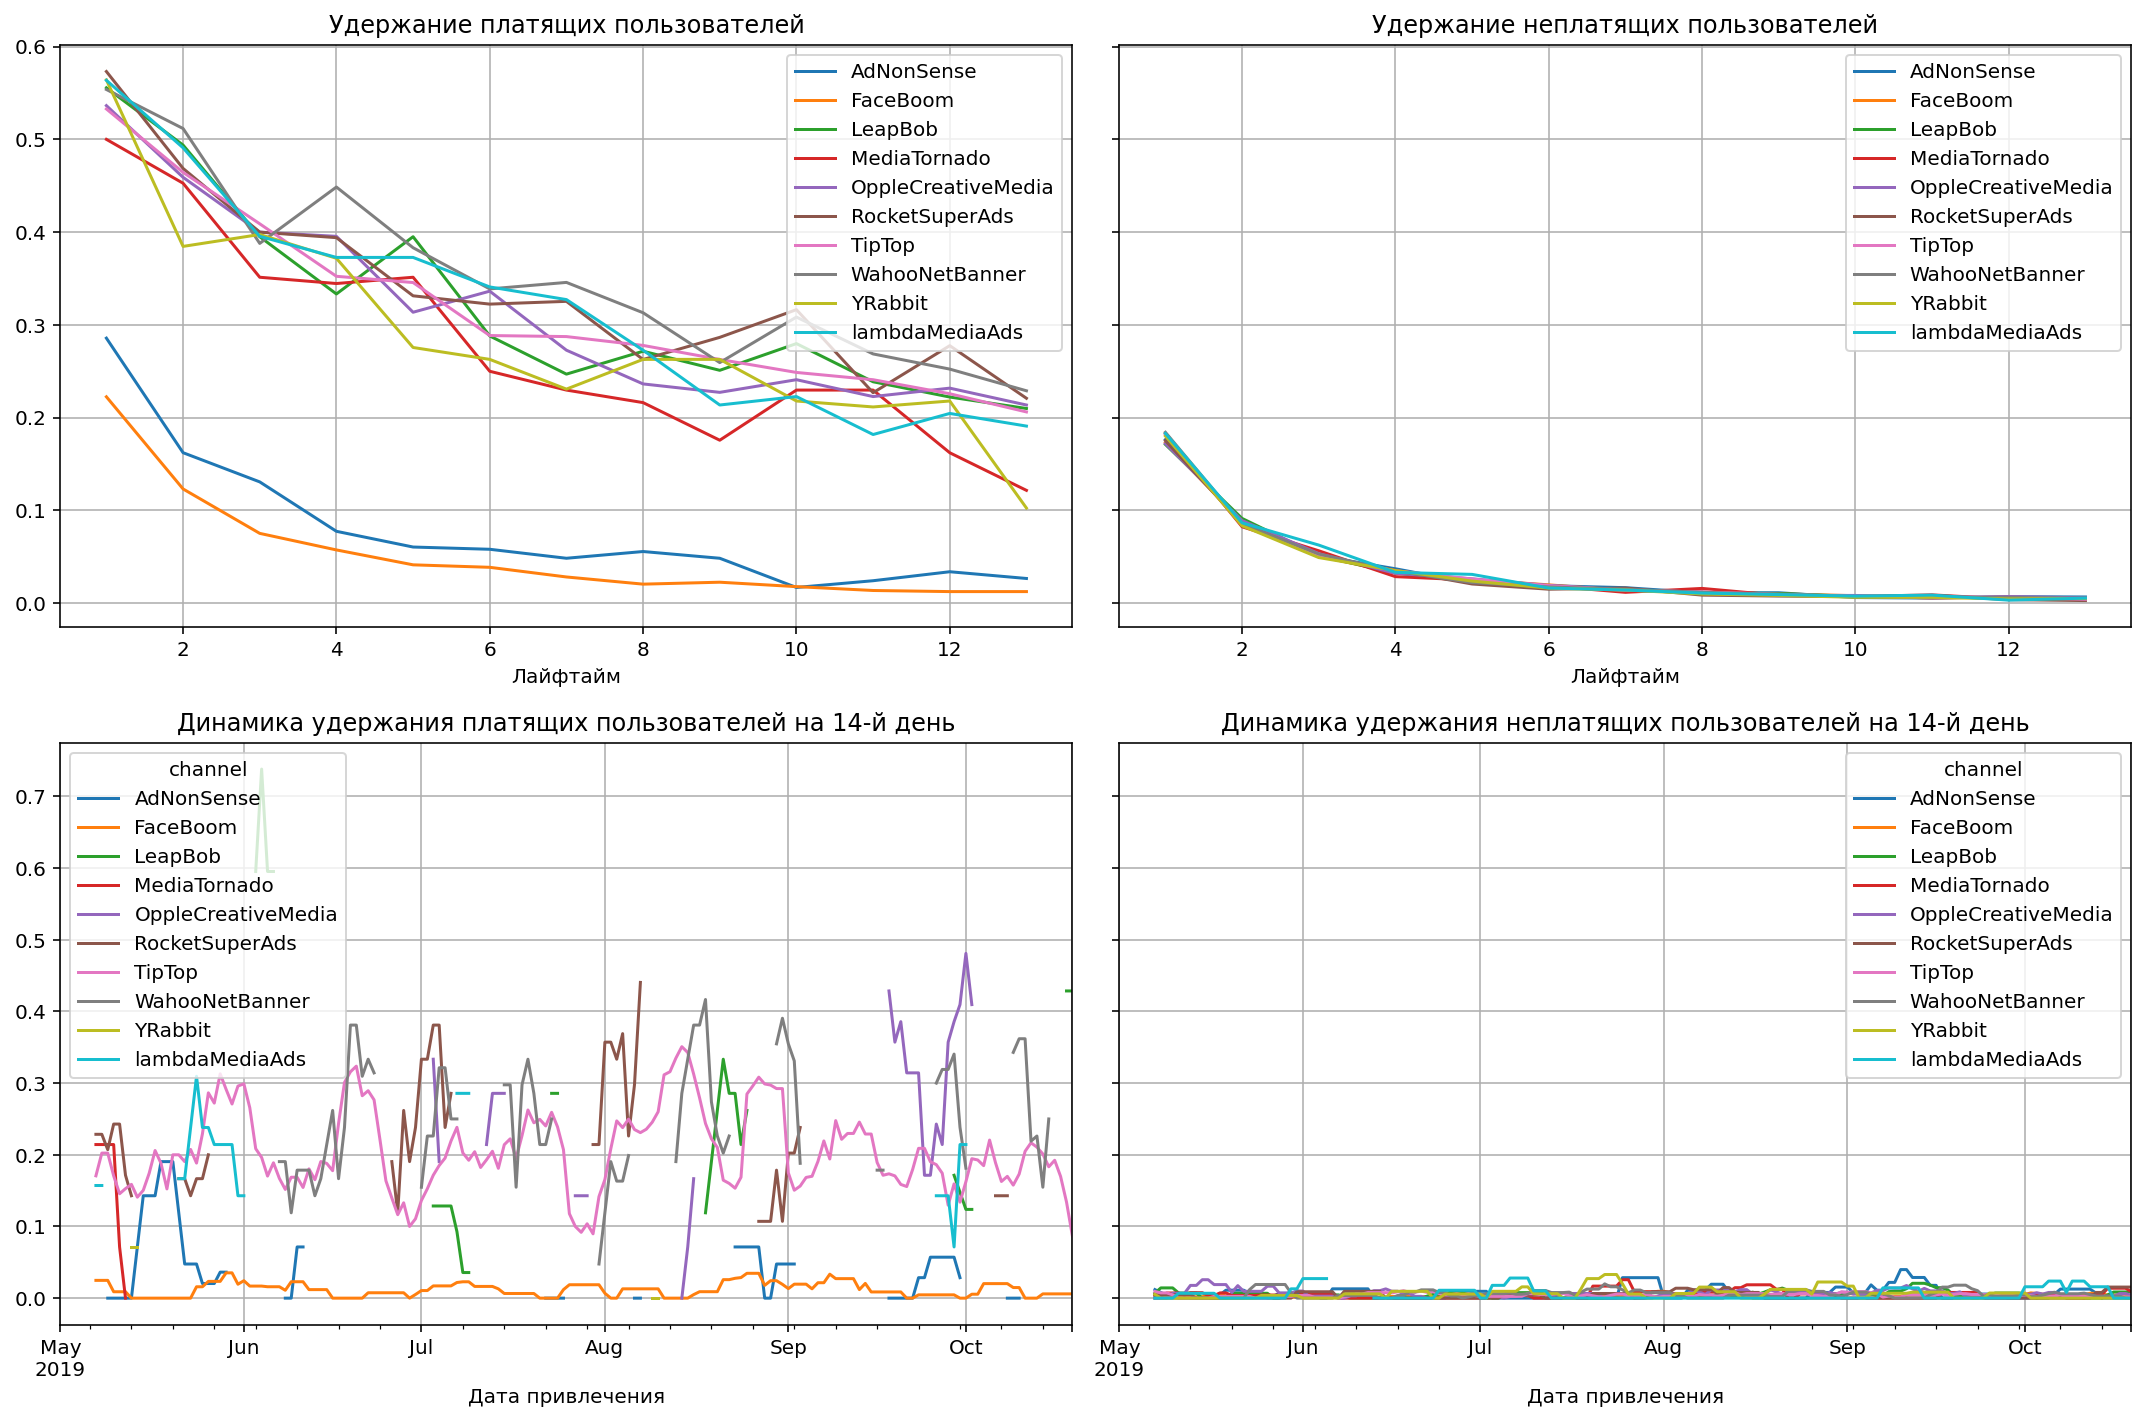

In [65]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Здесь мы уже видим другую картины.

- Худшее удержание пользователей по каналам `FaceBoom` и естественных пользователей.

- Остальные каналы показывают примерно одинаковые результаты удержания.

- Также стоит отметить, что удержания пользователей канала `FaceBoom` стабильно низкий за весь рассматриваемый период.

- Выделим дополнительно наличие заметных колебаний для всех каналов.

Можем сделать определенные выводы:

- **несмотря на высокую конверсию, удержание пользователей по каналу `FaceBoom` самое низкое среди всех каналов привлечения;**

- **большие колебания как конверсии, так и удержания практически для всех каналов привлечения.**

## 5.2. Оценка конверсии и удержания пользователей по регионам пользователей.

Теперь рассмотрим уровни конверсии и удержания пользователей в разрезе по регионам пользователей.

Зададим параметр `dimensions` как `'region'` и вызовем функции `get_conversion`, `plot_conversion`, `get_retention` и `plot_retention`.

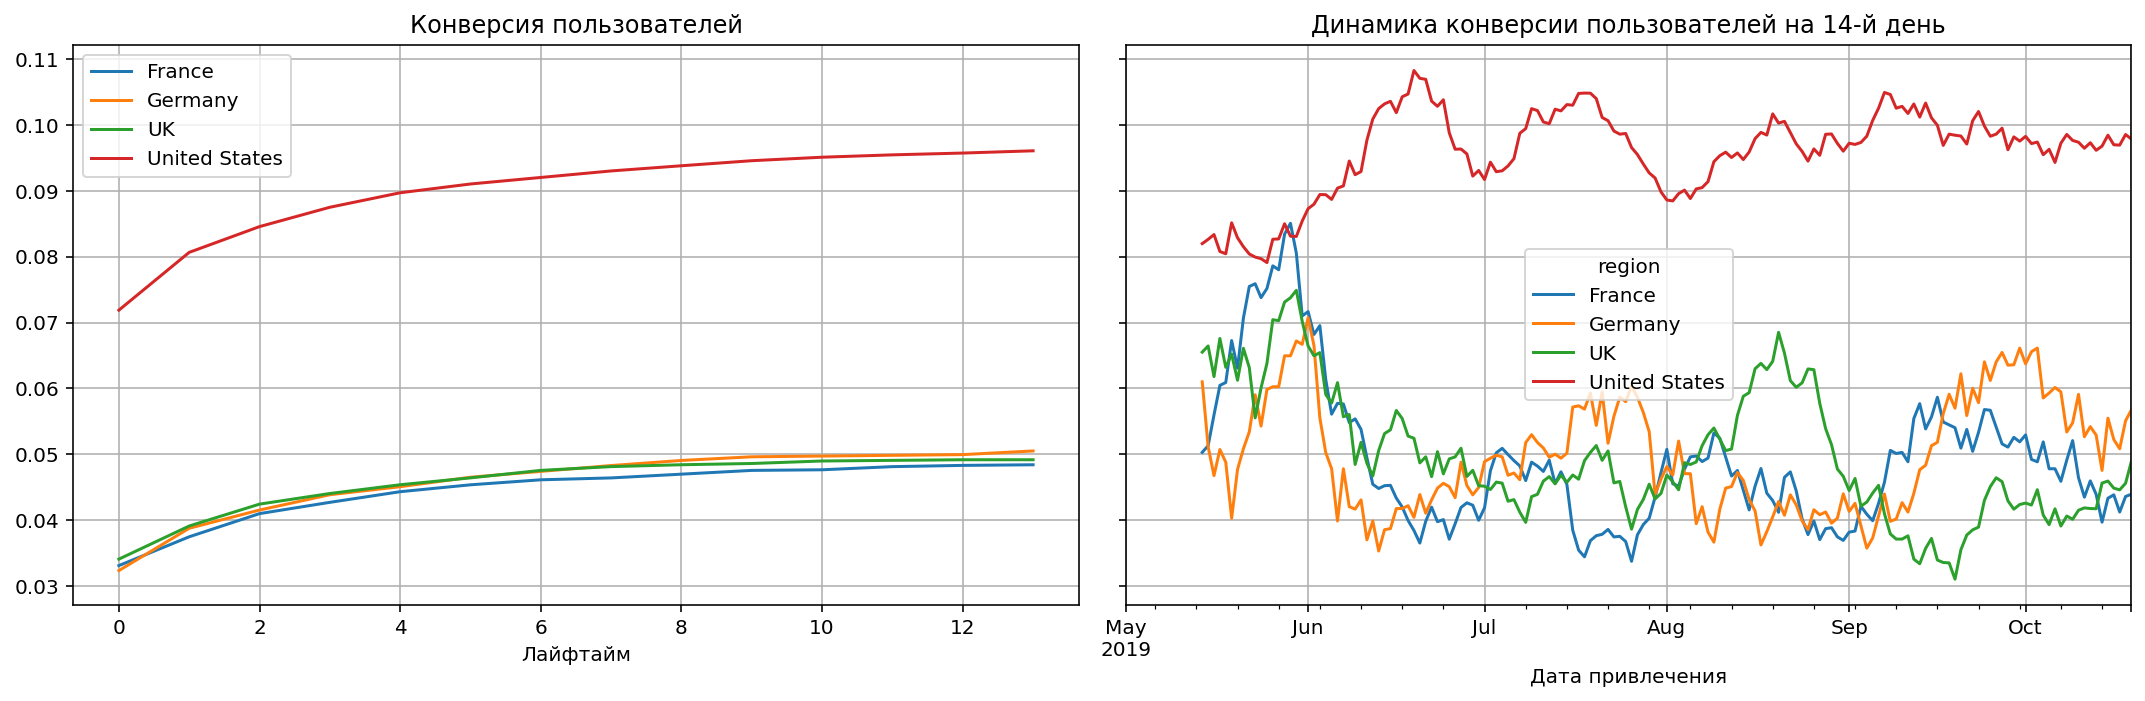

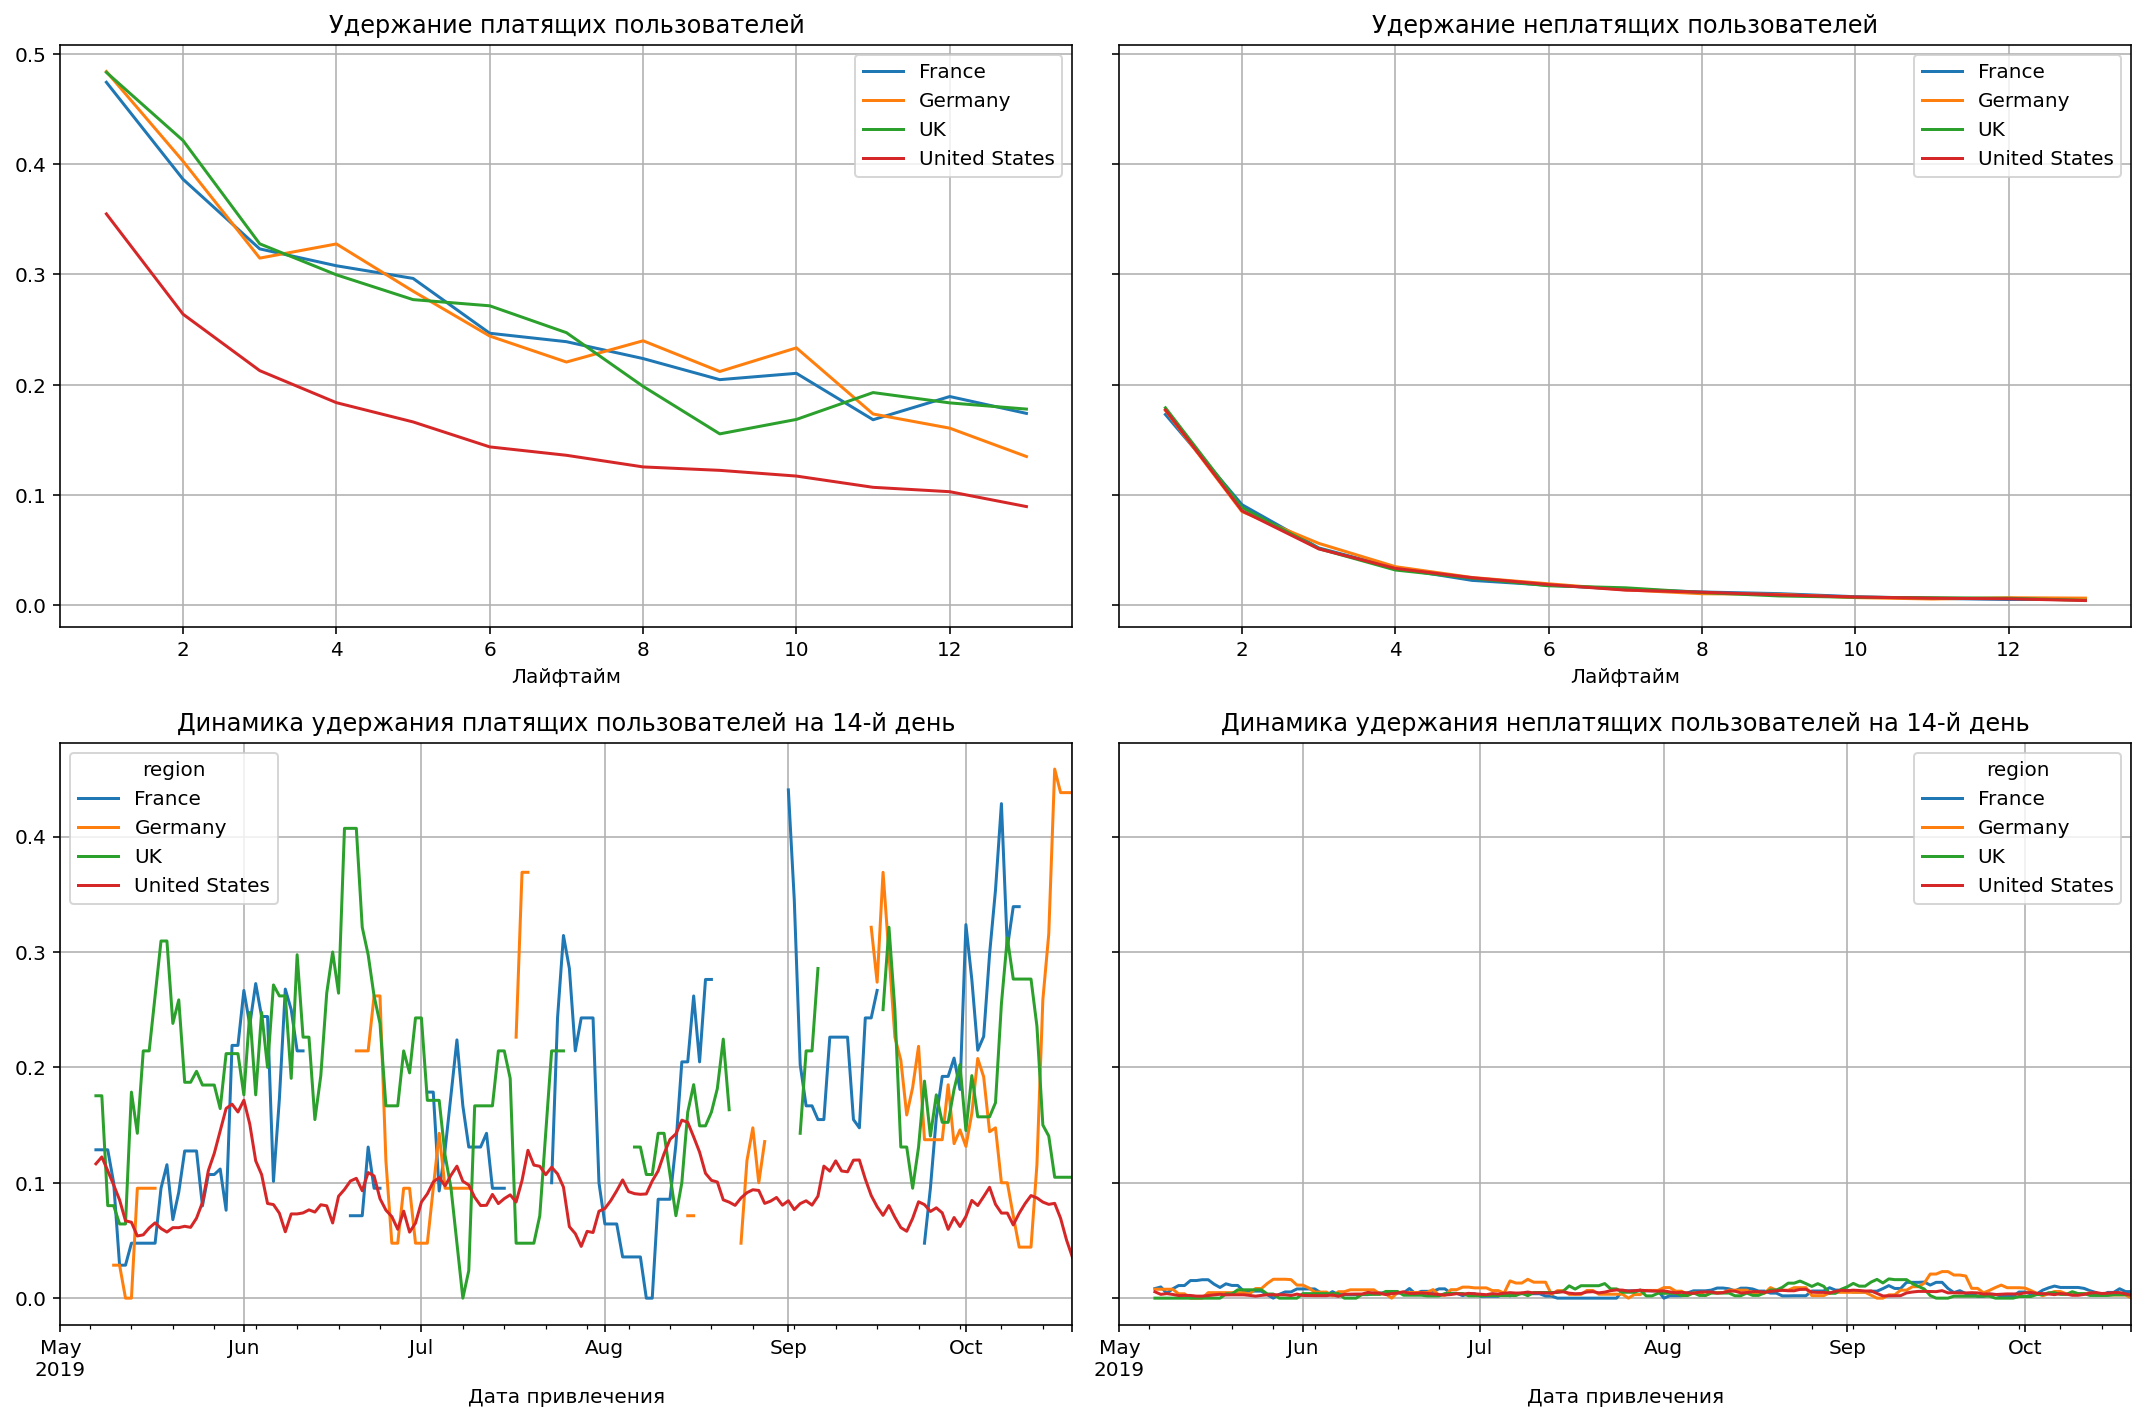

In [66]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

На этих графиках мы видим следующее: 

- конверсия пользователей в США намного выше, чем в других странах;

- также отметим, что конверсия в США увеличивается со временем, тогда как в других странах она стабильна;

- в тоже время удержание пользователей в США заметно ниже, чем в остальных странах;

- по динамике удержание в США меньше подвержено колебаниям, но и стабильно находится на более низком уровне.

Здесь важно отметить, что **конверсия пользователей в США самая высокая и она увеличивалась со временем**. Однако коэффициент удержания пользователей для **США самый низкий из всех стран и находится на стабильно низком уровне за весь рассматриваемый период**.

## 5.3. Оценка конверсии и удержания пользователей по используемым устройствам.

Ну и наконец, рассмотрим конверсию и удержание пользователей по признаку используемого устройства. Зададим параметр `dimensions` = ['device'].

И вызовем функции `get_conversion`, `plot_conversion`, `get_retention` и `plot_retention`.

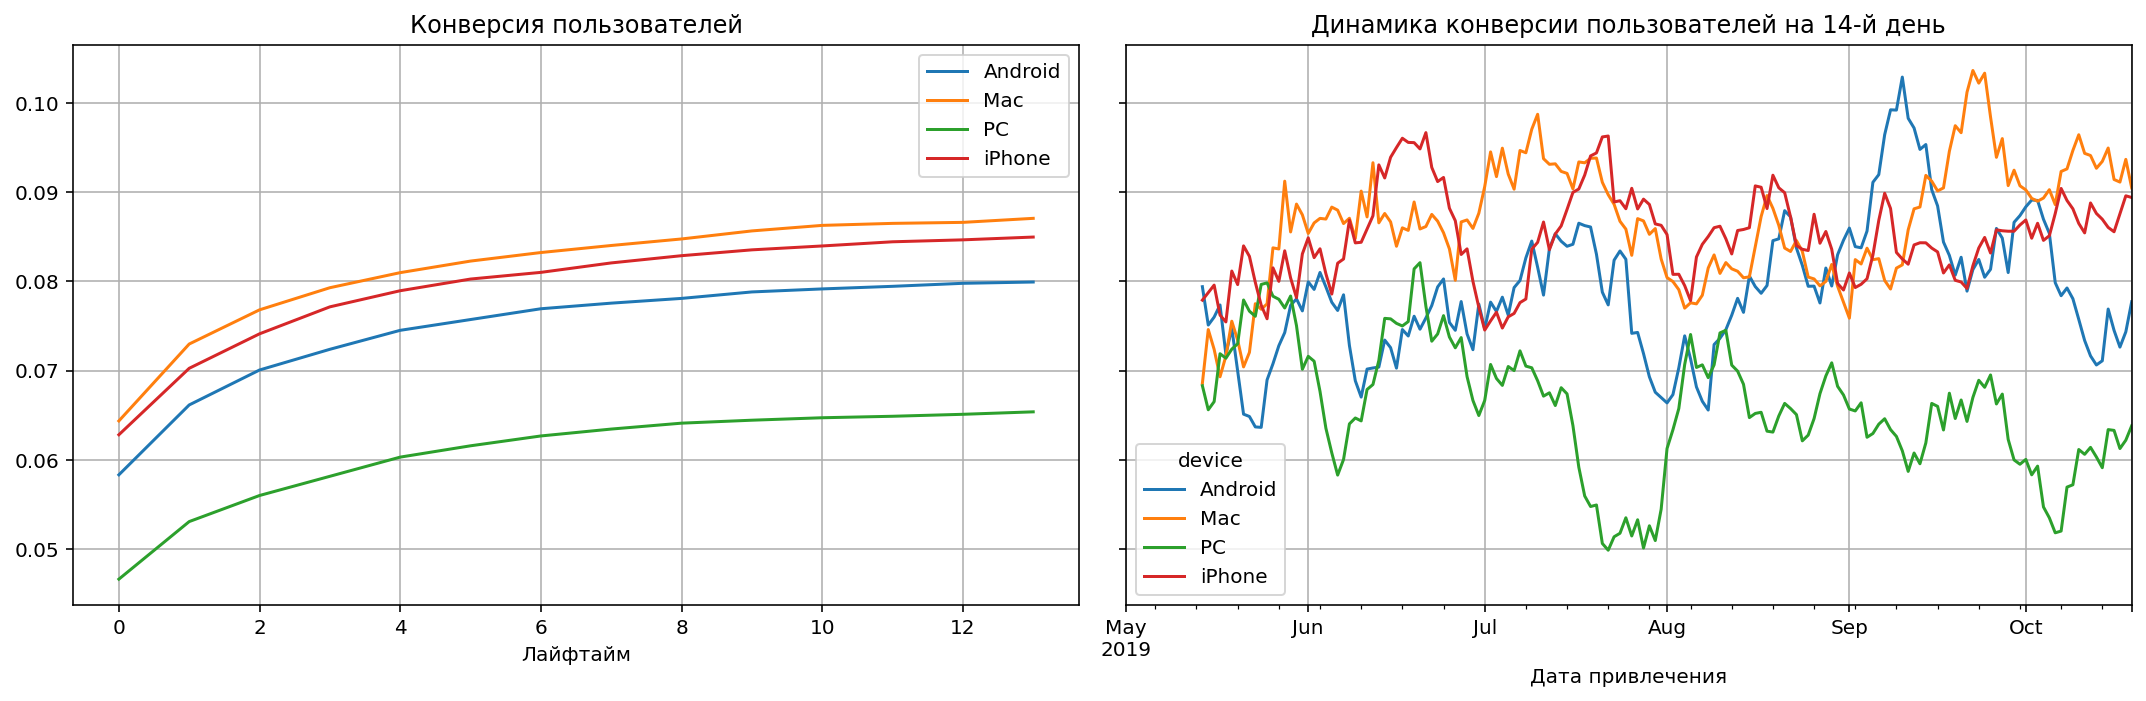

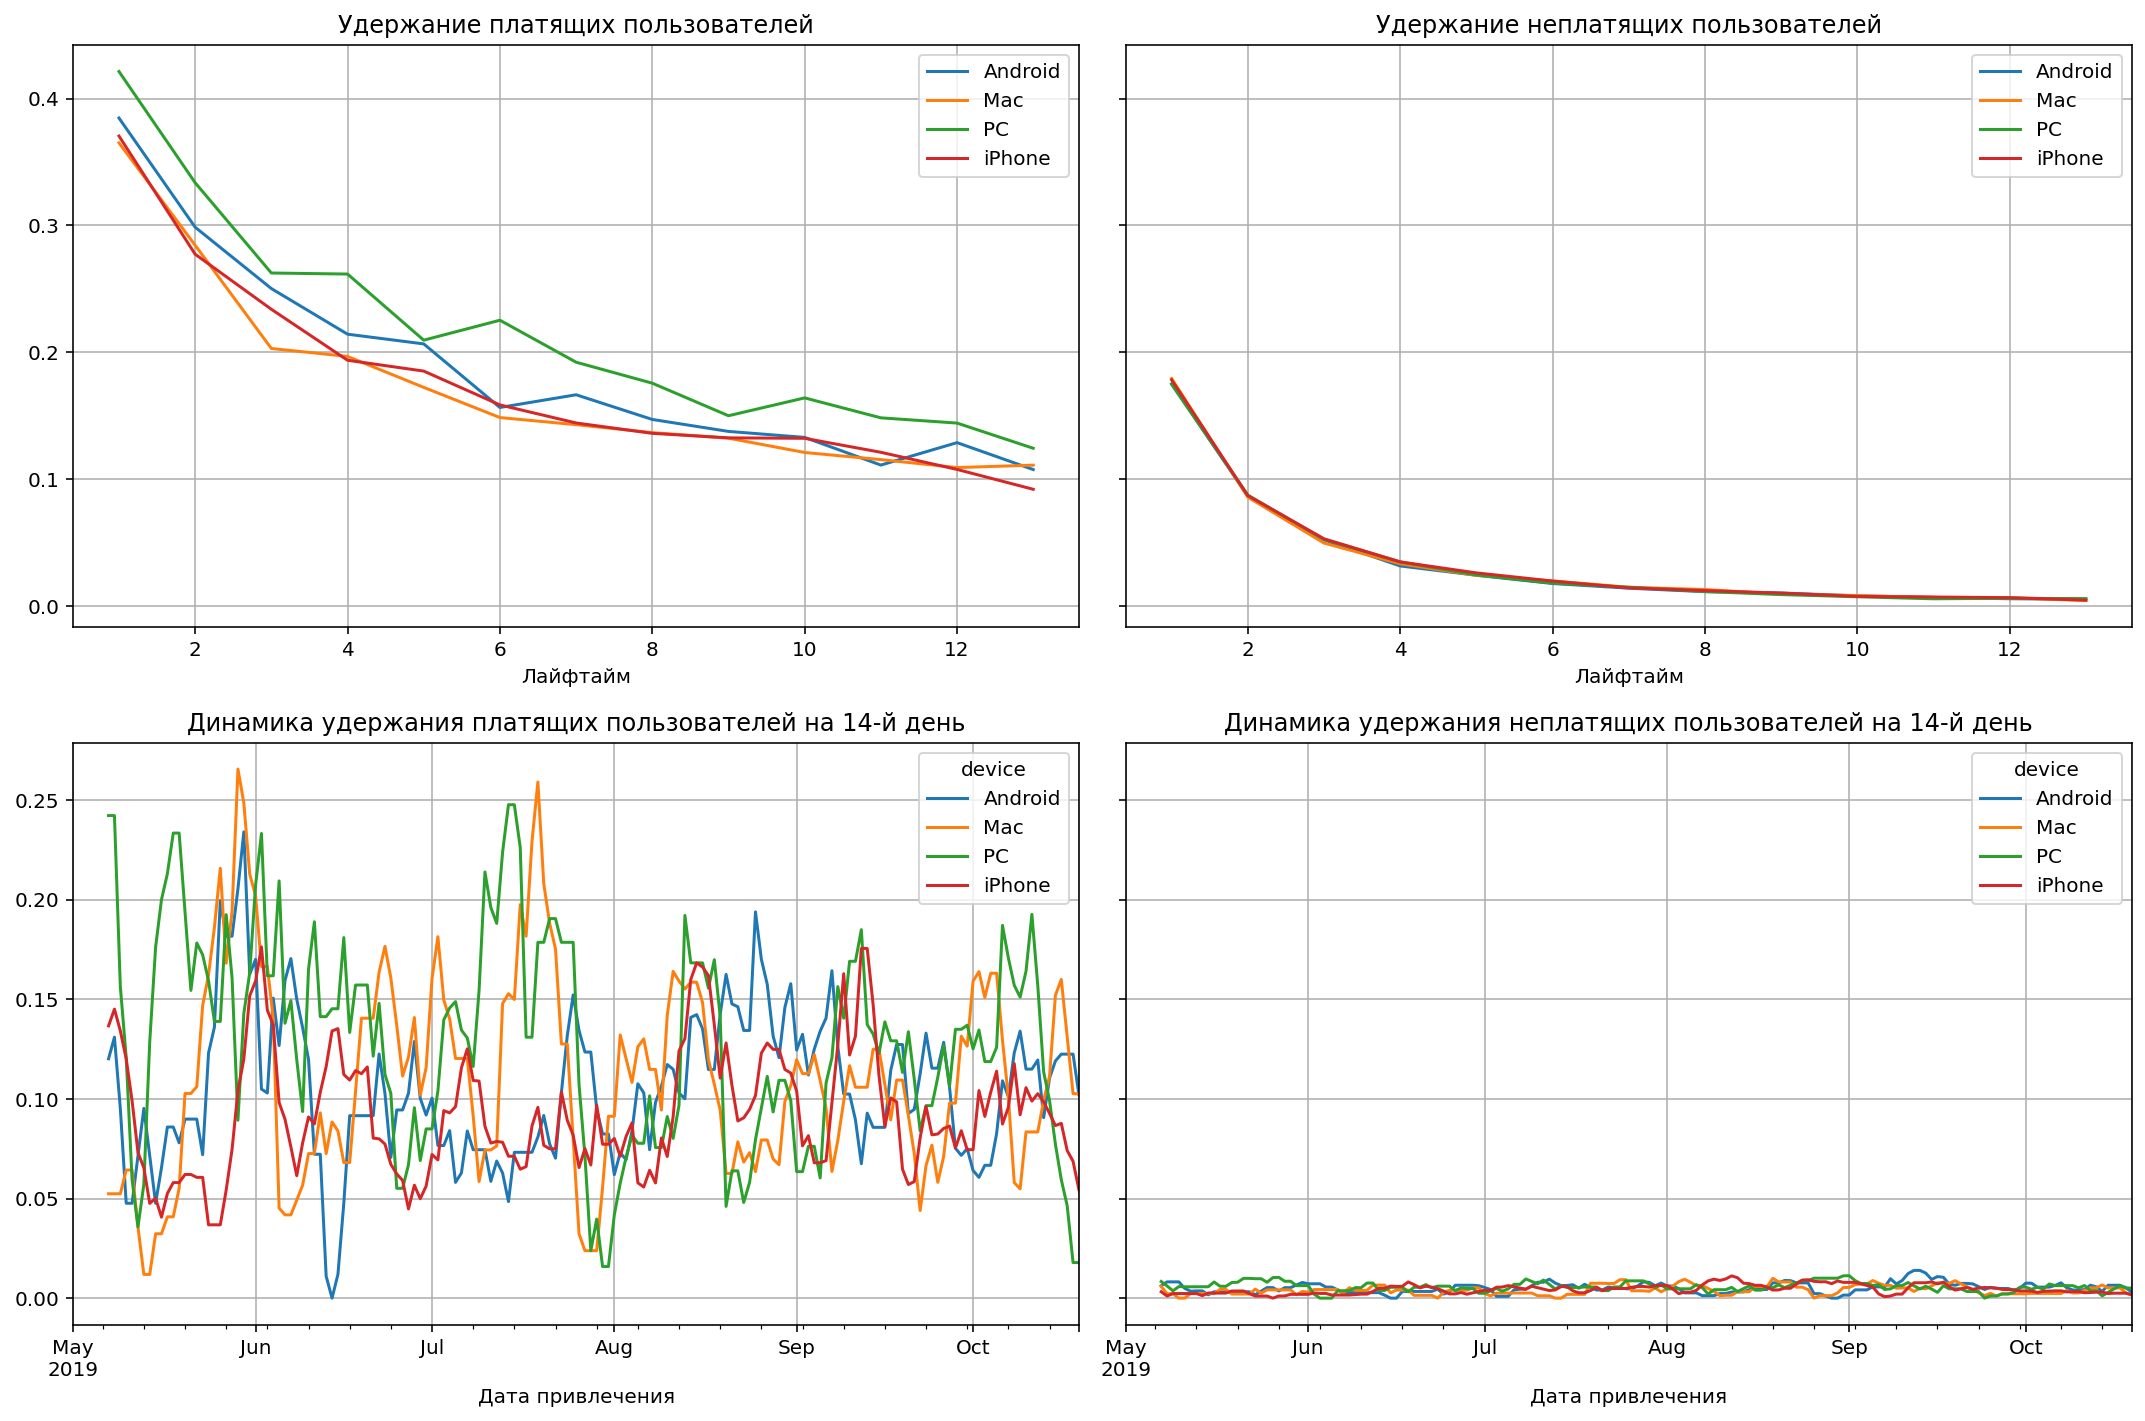

In [67]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По результатам можно заключить следующее: 

- наилучшая конверсия у пользователей устройств `iPhone` и `Mac`, а наименьшая у пользователей `PC`;

- динамика конверси у всех пользователей положительная - несмотря на значительные колебания, она увеличивается у всех типов используемых устройств;

- удержание для всех пользователей различны устройств примерно одинаковое, но для пользователей `PC` оно выше;

- во времени удержание для всех используемых устройств стабильно.

Делаем промежуточные выводы:

- **конверсия пользователей `PC` хуже, чем пользователей других устройств**;

- **удержание всех пользователей относительно стабильно и находится на примерно одинаковом уровне**.

Общий вывод по итогу анализа конверсии и удержания по различным признакам такой: **конверсия пользователей из США самая высокая, но и удержание пользователей из США самое низкое. Тоже самое можно определенно сказать про пользователей привлеченных по каналу `FaceBoom`: самая высокая конверсия и самое низкое удержание**

Теперь попробуем разобраться почему так происходит.

# 6. Выявление факторов, приведших к убыткам.

Ранее мы выявили, что самое худшое удержание показывают пользователи из США и привлеченные по каналу `FaceBoom`.

Также мы ранее отмечали, что пользователей из США подавляющее большинство, значит именно там и стоит искать проблему.

Проверим это сгруппировав наши пользовательские профили по региону и каналу привлечения.

In [68]:
profiles.groupby(['region', 'channel']).agg({'user_id':'nunique'})

user_id
region        channel                    
France        AdNonSense             1366
              LeapBob                2988
              OppleCreativeMedia     2991
              WahooNetBanner         2971
              lambdaMediaAds          742
Germany       AdNonSense             1219
              LeapBob                2519
              OppleCreativeMedia     2562
              WahooNetBanner         2579
              lambdaMediaAds          649
UK            AdNonSense             1295
              LeapBob                3046
              OppleCreativeMedia     3052
              WahooNetBanner         3003
              lambdaMediaAds          758
United States FaceBoom              29144
              MediaTornado           4364
              RocketSuperAds         4448
              TipTop                19561
              YRabbit                4312

Здесь явно видно, что самые массовые каналы привлечения - `TipTop` и `FaceBoom` - были задействованы только в США. А именно на эти каналы уходили основные затраты на рекламу.

Выделим в отдельную таблицу данные по США.

In [69]:
profiles.query('region == "United States"')\
.groupby('channel').agg({'user_id':'nunique'}).\
sort_values(by='user_id', ascending=False)

user_id
channel                
FaceBoom          29144
TipTop            19561
RocketSuperAds     4448
MediaTornado       4364
YRabbit            4312

Проверим сколько всего было потрачено средств на рекламу в разных регионах.

In [70]:
profiles.groupby('region').agg({'acquisition_cost':'sum'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost
region                         
United States      90928.600000
France              5075.973946
UK                  5068.502819
Germany             4424.223235

Мы видим, что за рассматриваемый период вложения в рекламу на территории США составили 90928,6 ед., что составляет около 90% от всех затрат на рекламу.

Посмотрим на затраты на рекламу по странам в динамике.

Text(10.65475405092593, 0.5, 'Стоимость, ед.')

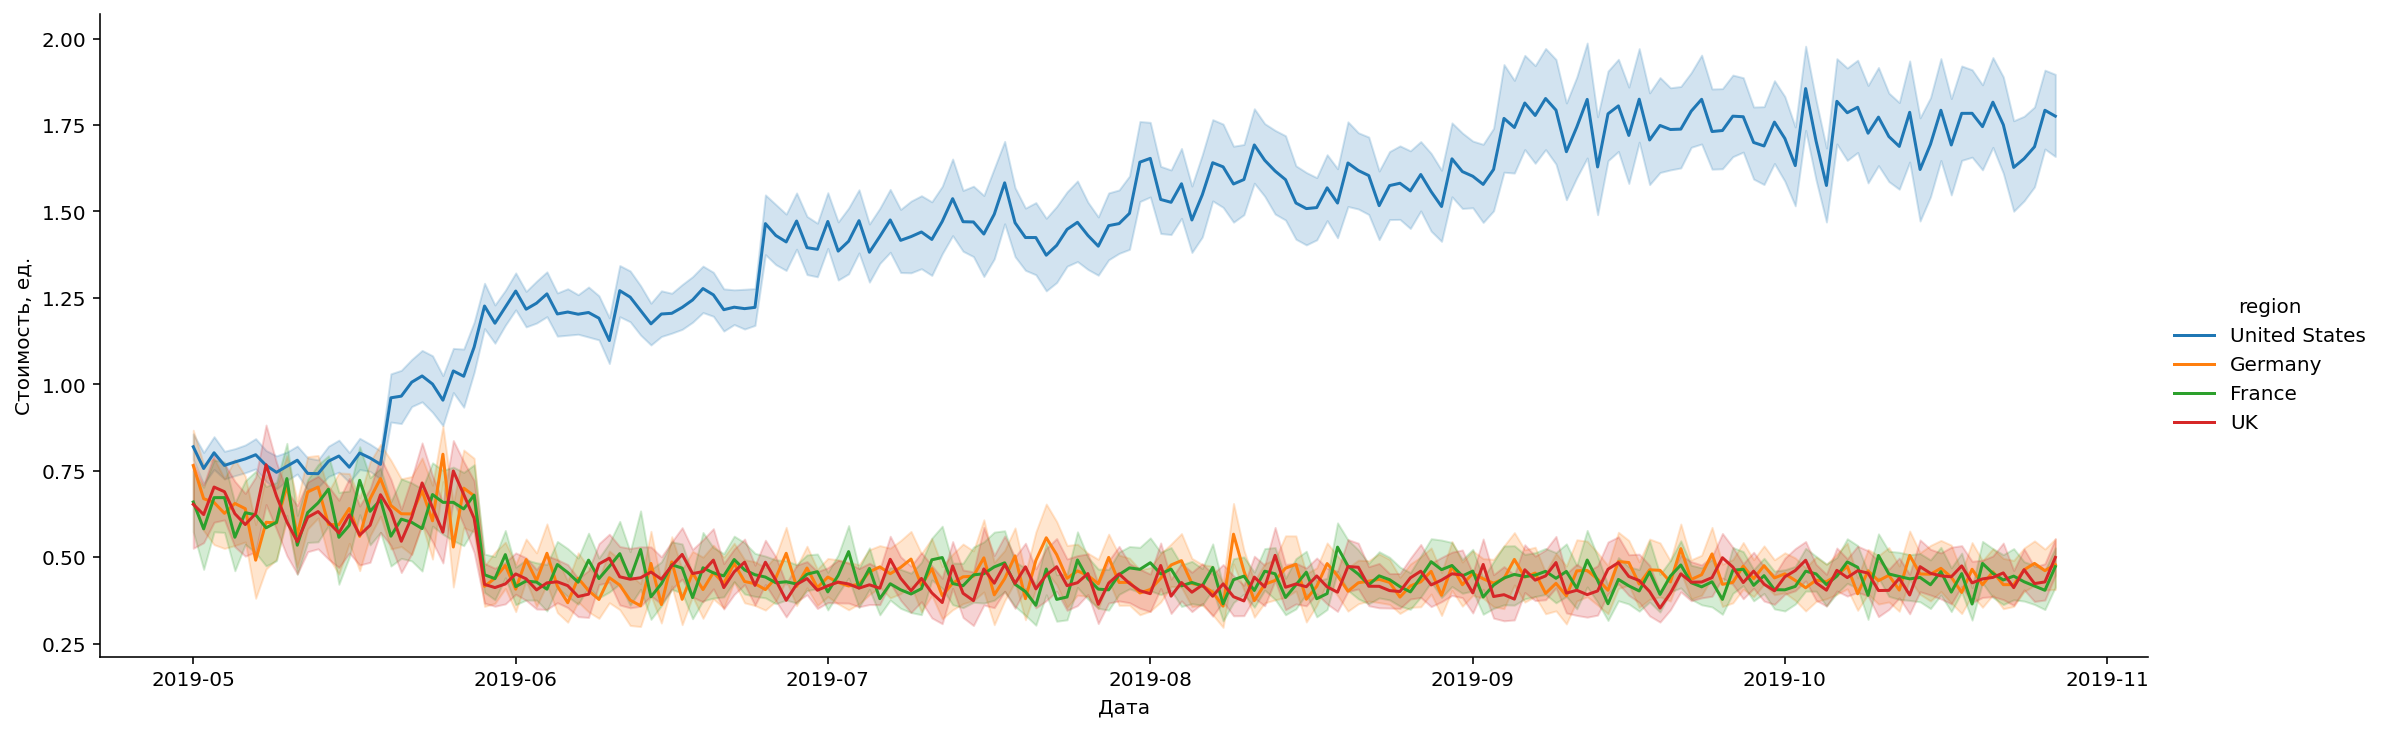

In [71]:
sns.relplot(x='dt', y='acquisition_cost', data=profiles, hue='region', kind='line', height=5, aspect=3)
plt.xlabel('Дата')
plt.ylabel('Стоимость, ед.')

Мы видим, что затраты в США росли в течении всего периода времени, особенно начиная с июня. Тогда как в других странах эти показатели оставались стабильными. Значит все дело в проведении рекламных компаний на территории США.

In [72]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Ранее мы также выявляли, что наибольшие затраты на продвижение были на каналы `TipTop` и `FaceBoom`.

И именно по этим каналам и в США мы наблюдаем наихудший коэффициент удержания из всех, несмотря на хорошуб конверсию.

**Наш вывод такой: затраты на рекламу в США, в особенности на каналы `TipTop` и `FaceBoom` себя не окупили, несмотря на большое количество привлеченных пользователй и высокую конверсию.**

# 7. Проверочная работа.

Для удостоверения, что все наши расчеты были сделаны верно, проведем проверочную работу.

Проверять будем удержание, конверсию, LTV, CAC и ROI .

## 7.1. Проверка Retantion Rate.

Начнем с удержания.

Зададим условную дату.

In [73]:
# считаем удержание

retention_raw, retention, retention_history = get_retention(
    profiles, sessions, datetime(2019, 5, 10).date(), 6
)

И проверим сумму размеров когорт, которая должна быть равна числу новых клиентов.

In [74]:
# сумма размеров когорт равна числу новых клиентов в изучаемый период?

report = profiles.query(
     # в профилях находим пользователей, привлечённых с 1 по 5 мая
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 5, 5).date()'
)
print(
    # считаем уникальных пользователей в профилях и складываем размеры когорт
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), retention['cohort_size'].sum()
    )
)

# сумма размеров платящих когорт равна числу покупателей в изучаемый период?

report = profiles.query(
    # в профилях находим платящих пользователей, привлечённых с 1 по 5 мая
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 5, 5).date() and payer == True'
)
print(
    # считаем уникальных платящих пользователей в профилях 
    # и складываем размеры платящих когорт
    'Общее количество новых покупателей: {} {}'.format(
        len(report['user_id'].unique()),
        retention.query('payer == True')['cohort_size'].sum(),
    )  
) 

Общее количество новых пользователей: 1954 1954
Общее количество новых покупателей: 156 156


Все верно.
Идем далее. Посмотрим на кривые удержания: кривая платящих пользователей должна быть выше неплатящих, и обе должны быть обратно-экспоненциальные и убывающие.

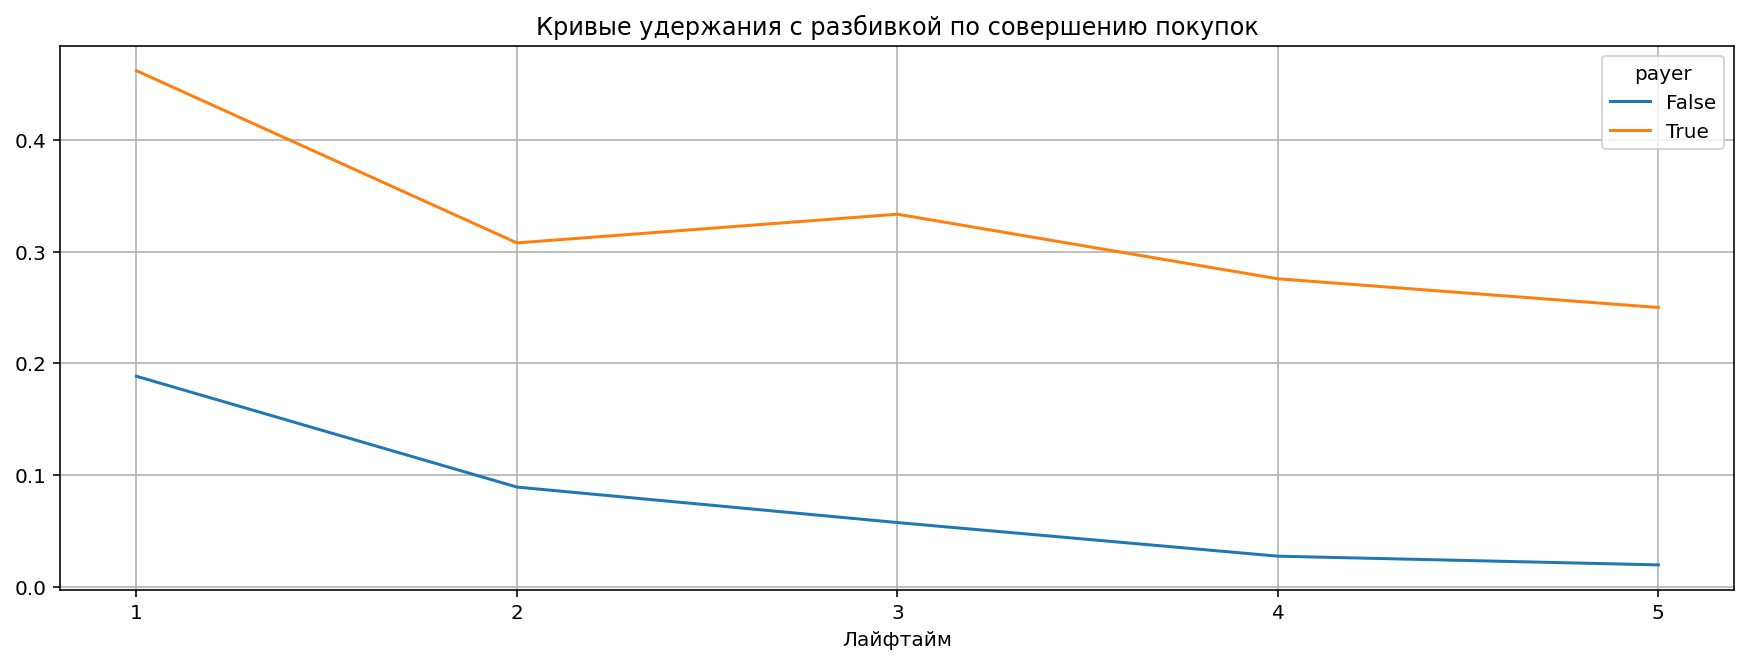

In [75]:
# строим кривые удержания

report = retention.drop(columns=['cohort_size', 0])
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(15, 5))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по совершению покупок')
plt.show() 

Все верно.

## 7.2. Проверка Conversion Rate.

Теперь проверим конверсию.

In [76]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 5, 12).date(), 7
)

print(conversion)  # таблица конверсии
print()
print(conversion_history)  # таблица динамики конверсии 

           cohort_size       0.0       1.0       2.0       3.0       4.0  \
cohort                                                                     
All users         2397  0.055903  0.064247  0.067167  0.070088  0.073842   

                5.0       6.0  
cohort                         
All users  0.074259  0.075094  

            cohort_size       0.0       1.0       2.0       3.0       4.0  \
dt                                                                          
2019-05-01          390  0.058974  0.066667  0.071795  0.071795  0.076923   
2019-05-02          323  0.058824  0.068111  0.068111  0.068111  0.068111   
2019-05-03          346  0.057803  0.069364  0.075145  0.078035  0.083815   
2019-05-04          457  0.070022  0.074398  0.076586  0.078775  0.085339   
2019-05-05          438  0.036530  0.043379  0.047945  0.052511  0.052511   
2019-05-06          443  0.054176  0.065463  0.065463  0.072235  0.076749   

                 5.0       6.0  
dt                      

Сумма размеров когорт также должна быть равна числу привлеченных клиентов.

In [77]:
# сумма размеров когорт равна числу новых клиентов в изучаемый период?

report = profiles.query(
    # в профилях находим пользователей, привлечённых с 1 по 5 мая
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 5, 6).date()'
)
print(
    # считаем уникальных пользователей в профилях и складываем размеры когорт
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), conversion['cohort_size'].sum()
    )
) 

Общее количество новых пользователей: 2397 2397


Все верно.

Далее построим кривую конверсии: она должна быть возрастающей и экспоненциальной и не превышать единицу..

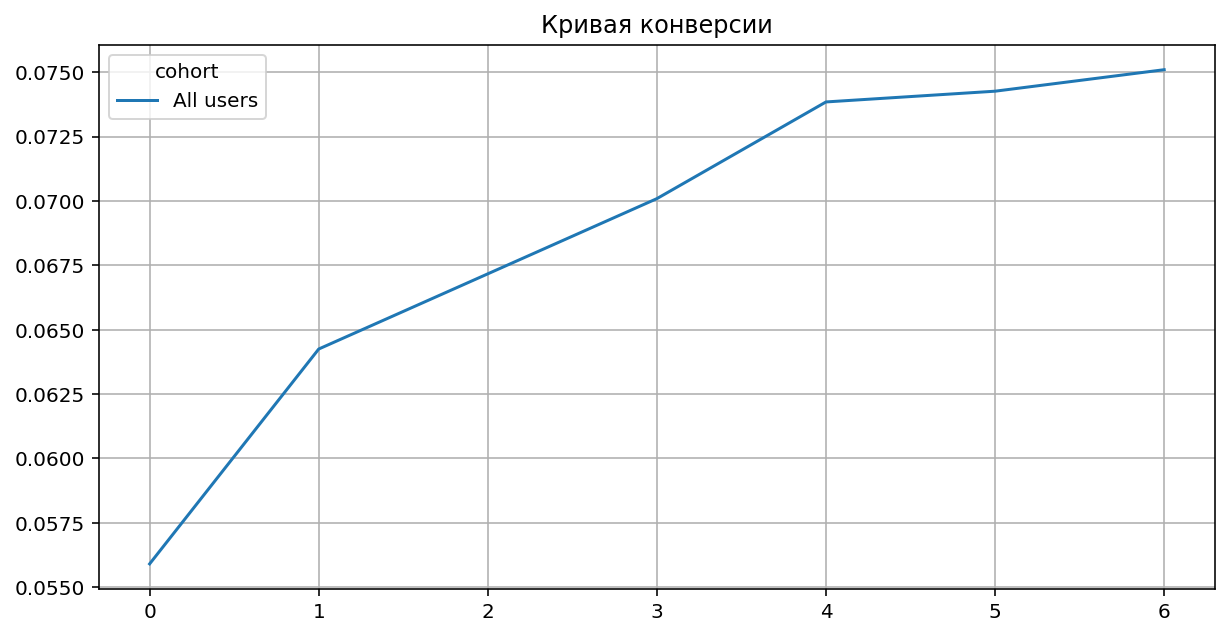

In [78]:
# строим кривую конверсии

report = conversion.drop(columns=['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(10, 5))
plt.title('Кривая конверсии')
plt.show() 

Все верно.

Теперь убедимся, что в таблицах конверсий нет значений больше единицы. Сделаем срез таблицы конверсии по условию > 1 и заменим остальные значения на пустую строку методом fillna(). Так в таблице останутся только значения больше единицы.

In [79]:
conversion[conversion > 1].fillna('')

cohort_size 0.0 1.0 2.0 3.0 4.0 5.0 6.0
cohort                                            
All users         2397

В таблице конверсии остался только размер когорты — CR выше единицы нет.

То же самое проделаем с таблицей динамики конверсии.

In [80]:
conversion_history[conversion_history > 1].fillna('')

cohort_size 0.0 1.0 2.0 3.0 4.0 5.0 6.0
dt                                                 
2019-05-01          390                            
2019-05-02          323                            
2019-05-03          346                            
2019-05-04          457                            
2019-05-05          438                            
2019-05-06          443

Все верно.

И последнее, сравним число уникальных покупателей из таблицы конверсии и число уникальных покупателей из таблицы заказов. Они должны совпадать.

In [81]:
print(
    'Количество уникальных покупателей из таблицы конверсии: {:.0f}'.format(
        conversion['cohort_size'][0] * conversion[6][0]
    )
) 

Количество уникальных покупателей из таблицы конверсии: 180


In [82]:
# рассчитываем число покупателей по данным о покупках

# берём данные пользователей, привлечённых между 1 и 6 мая
report = orders.merge(
    profiles.query(
        'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 5, 6).date()'
    ),
    on='user_id',
)
# рассчитываем лайфтайм для каждой покупки
report['lifetime'] = (report['event_dt'] - report['first_ts']).dt.days
# исключаем лишние лайфтаймы
report = report.query('lifetime <= 6')

print(
    'Количество уникальных покупателей из таблицы заказов: {:.0f}'.format(
        len(report['user_id'].unique())
    )
) 

Количество уникальных покупателей из таблицы заказов: 180


Все верно.

## 7.3. Проверка LTV.

Проверим расчеты LTV.

Построим кривую LTV: она должна напоминать кривую конверсии - расти по экспоненте - но она может быть выше единицы.

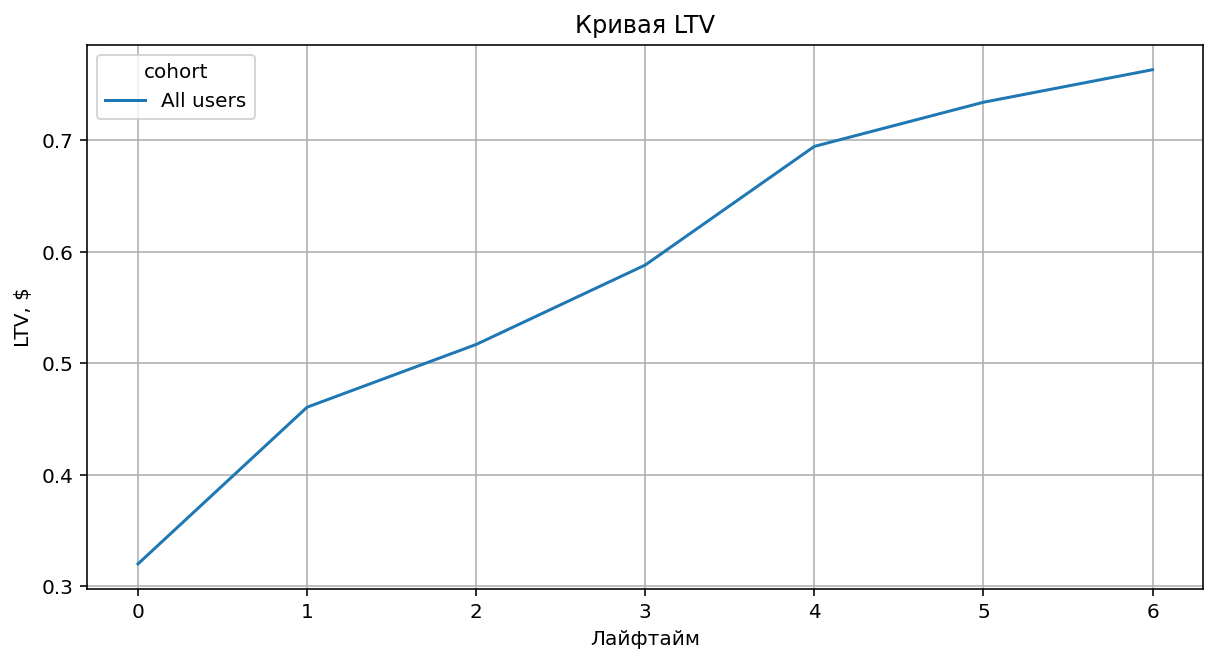

In [83]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 5, 12).date(), 7
)

# строим кривую LTV
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('Кривая LTV')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show() 

Все верно.

Теперь убедимся, что общая стоимость покупок новых клиентов равна максимальному LTV, умноженному на число новых клиентов.

Для этого выполним следующие действия.

In [84]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_one, orders, datetime(2019, 5, 12).date(), 6
)

# считаем максимальный горизонт анализа
# в теле функции get_ltv() мы вычитаем из горизонта анализа единицу,
# поэтому заранее добавляем 1, чтобы максимально «расширить» горизонт
max_horizon = int(ltv_raw['lifetime'].max() + 1)

# находим максимальный момент анализа
max_date = profiles['dt'].max()

print(max_horizon, max_date) 

184 2019-10-27 00:00:00


In [85]:
# считаем LTV с максимальными горизонтом и моментом анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_one, orders, max_date, max_horizon, ignore_horizon=True
)
print(ltv) 

           cohort_size       0.0       1.0       2.0       3.0       4.0  \
cohort                                                                     
All users       150008  0.243063  0.313111  0.367054  0.411443  0.450483   

                5.0       6.0       7.0       8.0  ...     174.0     175.0  \
cohort                                             ...                       
All users  0.484283  0.514965  0.542292  0.569055  ...  1.438711  1.438844   

              176.0     177.0    178.0    179.0     180.0     181.0     182.0  \
cohort                                                                          
All users  1.439044  1.439144  1.43931  1.43941  1.439476  1.439509  1.439642   

              183.0  
cohort               
All users  1.439676  

[1 rows x 185 columns]


In [86]:
# сравниваем выручку в таблице LTV и данных о покупках

print(
    'Общая стоимость заказов из таблицы LTV: {:.2f}'.format(
        ltv.loc['All users', 183] * ltv.loc['All users', 'cohort_size']
    )
)

print(
    'Общая стоимость заказов из таблицы заказов: {:.2f}'.format(
        orders['revenue'].sum()
    )
) 

Общая стоимость заказов из таблицы LTV: 215962.88
Общая стоимость заказов из таблицы заказов: 215962.88


Все верно.

## 7.4. Проверка САС.

Проверим САС.

Для этого необходимо CAC из таблицы ROI, умноженный на размер когорты, равен сумме рекламных трат за изучаемый период.

In [87]:
# рассчитываем LTV и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 5, 12).date(), 7
)

print(roi)  # таблица ROI 

           cohort_size       cac       0.0       1.0       2.0       3.0  \
cohort                                                                     
All users         2397  0.742785  0.431109  0.620111  0.695783  0.791635   

                4.0       5.0       6.0  
cohort                                   
All users  0.934671  0.987927  1.027164  


In [88]:
max_acquisition_date = roi_history.reset_index()['dt'].max()
print(max_acquisition_date) 

2019-05-06 00:00:00


In [89]:
# сравниваем расходы на привлечение в таблице ROI и тратах на рекламу

print(
   'Общие расходы на привлечение из таблицы ROI: {:.2f}'.format(
       roi.loc['All users', 'cac'] * roi.loc['All users', 'cohort_size']
   )
)

print(
   'Общие расходы на привлечение из таблицы costs: {:.2f}'.format(
       costs.query('dt <= @max_acquisition_date')['costs'].sum()
   )
)

Общие расходы на привлечение из таблицы ROI: 1780.45
Общие расходы на привлечение из таблицы costs: 1780.45


Все верно.

Ошибок в наших расчетах быть не должно! Можно переходить к выводам и рекомендациям.

# 8. Общий вывод и рекомендации.

По итогам нашего небольшого расследования мы выявили, что на убыточность приложения в последнее `Procrastinate Pro+` повлияли ошибочные маркетинговые решения в части продвижения продукта на территории США с помощью каналов `TipTop` и `FaceBoom`. На это указывают факты самого низкого показателя удержания и заметные рекламные расходы: 90% всех расходов было затрачено на продвижение в США и 85% расходов на каналы `TipTop` и `FaceBoom`. К тому же мы видим, что расходы на привлечение пользователей именно по этим критериям росли за весь период, тогда как остальные оставались неизменными.

Особо следует отметить, что в виду отсутствия дополнительных данных, мы не можем сделать очевидный вывод о том, почему по этим признакам были самые низкие показатели удержания.

Основываясь на всем вешеперечисленном, можно порекомендовать маркетинговому отделу:

- проанализировать как велся учет рекламы по каналам `TipTop` и `FaceBoom`.;

- обосновать правильность вложения подавляющего количества средств в одно направление;

- рассмотреть переориентирование затрат на привлечение пользователей на более стабильные каналы;

- учитывая размеры и платежеспособность рынка в США, найти способы перераспределения затрат на каналы с лучшим удержанием: `YRabbit`, `RocketSuperAds`, `MediaTornado`.

- для более детального анализа необходимо запросить дополнительные данные по пользовательским событиям.